This notebook borrows the work of https://github.com/k-sys/covid-19

## Estimating COVID-19's $R_t$ in Real-Time
Kevin Systrom - April 17

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) changes $R_t$. Knowing the current $R_t$ is essential. When $R<1$, the pandemic will spread through a large part of the population. If $R_t<1$, the pandemic will slow quickly before it has a chance to infect many people. The lower the $R_t$: the more manageable the situation. In general, any $R_t<1$ means things are under control.

The value of $R_t$ helps us in two ways. (1) It helps us understand how effective our measures have been controlling an outbreak and (2) it gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. Well-respected epidemiologists argue that tracking $R_t$ is the only way to manage through this crisis.

Yet, today, we don't yet use $R_t$ in this way. In fact, the only real-time measure I've seen has been for Hong Kong. More importantly, it is not useful to understand $R_t$ at a national level. Instead, to manage this crisis effectively, we need a local (state, county and/or city) granularity of $R_t$.

What follows is a solution to this problem at the US State level. It's a modified version of a solution created by Bettencourt & Ribeiro 2008 to estimate real-time $R_t$ using a Bayesian approach. While this paper estimates a static $R$ value, here we introduce a process model with Gaussian noise to estimate a time-varying $R_t$.

If you have questions, comments, or improvments feel free to get in touch: hello@systrom.com. And if it's not entirely clear, I'm not an epidemiologist. At the same time, data is data, and statistics are statistics and this is based on work by well-known epidemiologists so you can calibrate your beliefs as you wish. In the meantime, I hope you can learn something new as I did by reading through this example. Feel free to take this work and apply it elsewhere – internationally or to counties in the United States.

Additionally, a huge thanks to Frank Dellaert who suggested the addition of the process and to Adam Lerer who implemented the changes. Not only did I learn something new, it made the model much more responsive.

In [18]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico',
]

%config InlineBackend.figure_format = 'retina'

Bettencourt & Ribeiro's Approach
Every day, we learn how many more people have COVID-19. This new case count gives us a clue about the current value of $R_t$. We also, figure that the value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every previous value of $R_{t-m}$ for that matter.

With these insights, the authors use Bayes' rule to update their beliefs about the true value of $R_t$ based on how many new cases have been reported each day.

This is Bayes' Theorem as we'll use it:

$$ P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)} $$
This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

The likelihood of seeing $k$ new cases given $R_t$ times ...
The prior beliefs of the value of $P(R_t)$ without the data ...
divided by the probability of seeing this many cases in general.
This is for a single day. To make it iterative: every day that passes, we use yesterday's prior $P(R_{t-1})$ to estimate today's prior $P(R_t)$. We will assume the distribution of $R_t$ to be a Gaussian centered around $R_{t-1}$, so $P(R_t|R_{t-1})=\mathcal{N}(R_{t-1}, \sigma)$, where $\sigma$ is a hyperparameter (see below on how we estimate $\sigma$). So on day one:

$$ P(R_1|k_1) \propto P(R_1)\cdot \mathcal{L}(R_1|k_1)$$
On day two:

$$ P(R_2|k_1,k_2) \propto P(R_2)\cdot \mathcal{L}(R_2|k_2) = \sum_{R_1} {P(R_1|k_1)\cdot P(R_2|R_1)\cdot\mathcal{L}(R_2|k_2) }$$
etc.

Choosing a Likelihood Function $P\left(k_t|R_t\right)$
A likelihood function function says how likely we are to see $k$ new cases, given a value of $R_t$.

Any time you need to model 'arrivals' over some time period of time, statisticians like to use the Poisson Distribution. Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to the Poisson distribution:

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

## Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count gives us a clue about the current value of $R_t$. We also, figure that the value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every previous value of $R_{t-m}$ for that matter.

With these insights, the authors use [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) to update their beliefs about the true value of $R_t$ based on how many new cases have been reported each day.

This is Bayes' Theorem as we'll use it:

$$ P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)} $$

This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

- The likelihood of seeing $k$ new cases given $R_t$ times ...
- The prior beliefs of the value of $P(R_t)$ without the data ...
- divided by the probability of seeing this many cases in general.

This is for a single day. 

To make it iterative: every day that passes, we use yesterday's prior $P(R_{t-1})$ to estimate today's prior $P(R_t)$. We will assume the distribution of $R_t$ to be a Gaussian centered around $R_{t-1}$, so $P(R_t|R_{t-1})=\mathcal{N}(R_{t-1}, \sigma)$, where $\sigma$ is a hyperparameter (see below on how we estimate $\sigma$). So on day one:

$$ P(R_1|k_1) \propto P(R_1)\cdot \mathcal{L}(R_1|k_1)$$

On day two:

$$ P(R_2|k_1,k_2) \propto P(R_2)\cdot \mathcal{L}(R_2|k_2) = \sum_{R_1} {P(R_1|k_1)\cdot P(R_2|R_1)\cdot\mathcal{L}(R_2|k_2) }$$
etc.

### Choosing a Likelihood Function $\mathcal{L}\left(k_t|R_t\right)$

A likelihood function function says how likely we are to see $k$ new cases, given a value of $R_t$.

Any time you need to model 'arrivals' over some time period of time, statisticians like to use the [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to the Poisson distribution:

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

In [3]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


> __Note__: this was a terse expression which makes it tricky. All I did was to make $k$ a column. By giving it a column for $k$ and a 'row' for lambda it will evaluate the pmf over both and produce an array that has $k$ rows and lambda columns. This is an efficient way of producing many distributions all at once, and __you will see it used again below__!

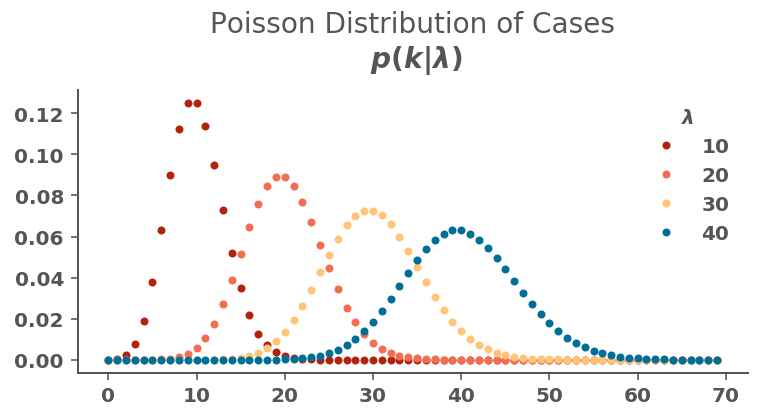

In [4]:
fig, ax = plt.subplots(figsize=(6,2.5))

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

The Poisson distribution says that if you think you're going to have $\lambda$ cases per day, you'll probably get that many, plus or minus some variation based on chance.

But in our case, we know there have been $k$ cases and we need to know what value of $\lambda$ is most likely. In order to do this, we fix $k$ in place while varying $\lambda$. __This is called the likelihood function.__

For example, imagine we observe $k=20$ new cases, and we want to know how likely each $\lambda$ is:

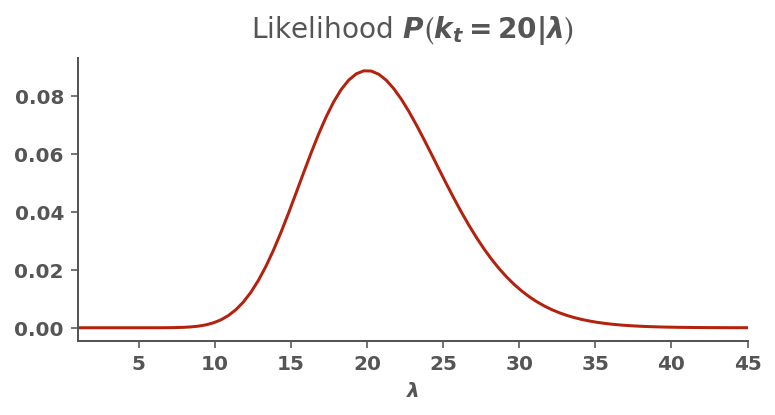

In [5]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$', figsize=(6,2.5));

This says that if we see 20 cases, the most likely value of $\lambda$ is (not surprisingly) 20. But we're not certain: it's possible lambda was 21 or 17 and saw 20 new cases by chance alone. It also says that it's unlikely $\lambda$ was 40 and we saw 20.

Great. We have $\mathcal{L}\left(\lambda_t|k_t\right)$ which is parameterized by $\lambda$ but we were looking for $\mathcal{L}\left(k_t|R_t\right)$ which is parameterized by $R_t$. We need to know the relationship between $\lambda$ and $R_t$

### Connecting $\lambda$ and $R_t$

__The key insight to making this work is to realize there's a connection between $R_t$ and $\lambda$__. [The derivation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) is beyond the scope of this notebook, but here it is:

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

where $\gamma$ is the reciprocal of the serial interval [(about 7 days for COVID19)](https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article). Since we know every new case count on the previous day, we can now reformulate the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

$$\mathcal{L}\left(R_t|k\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

### Evaluating the Likelihood Function

To continue our example, let's imagine a sample of new case counts $k$. What is the likelihood of different values of $R_t$ on each of those days?

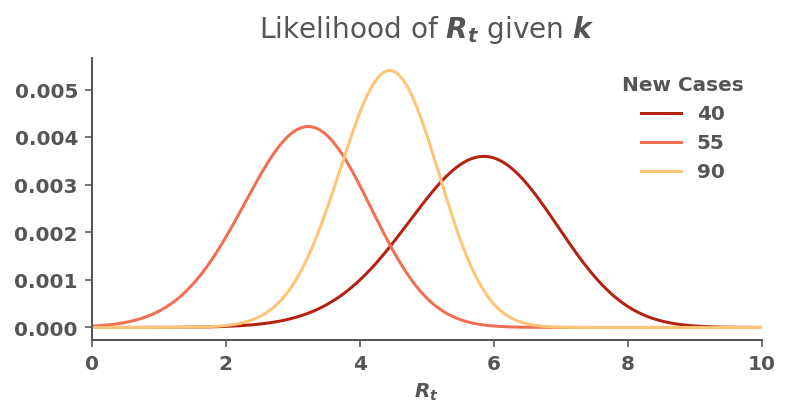

In [8]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = float(1)/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10),
    figsize=(6,2.5)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

You can see that each day we have a independent guesses for $R_t$. The goal is to combine the information we have about previous days with the current day. To do this, we use Bayes' theorem.

### Performing the Bayesian Update

To perform the Bayesian update, we need to multiply the likelihood by the prior (which is just the previous day's likelihood) to get the posteriors. Let's do that using the cumulative product of each successive day:

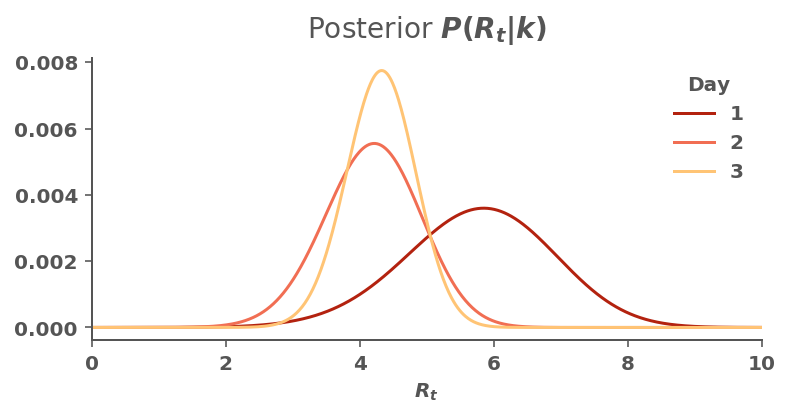

In [9]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10),
    figsize=(6,2.5)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

Notice how on Day 1, our posterior matches Day 1's likelihood from above? That's because we have no information other than that day. However, when we update the prior using Day 2's information, you can see the curve has moved left, but not nearly as left as the likelihood for Day 2 from above. This is because Bayesian updating uses information from both days and effectively averages the two. Since Day 3's likelihood is in between the other two, you see a small shift to the right, but more importantly: a narrower distribution. We're becoming __more__ confident in our believes of the true value of $R_t$.

From these posteriors, we can answer important questions such as "What is the most likely value of $R_t$ each day?"

In [13]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

We can also obtain the [highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) for $R_t$:

In [226]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        # my fix: should probably make a PR
        pmf = pmf.dropna(axis=1)
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = [], []
    _p = p
    while _p > (p-0.05):
        lows, highs = (total_p > _p).nonzero()
        if len(lows) + len(highs) < 2:
            _p-=0.01
            print('trying for p=%s'%_p)
        else:
            break
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high], index=['Low_%02d'%(p*100,), 'High_%02d'%(p*100,)])

hdi = highest_density_interval(posteriors)
hdi.tail()

Low_90  High_90
fips  date                       
48251 2020-05-04    0.02     2.77
      2020-05-05    0.03     2.67
      2020-05-06    0.00     2.56
      2020-05-07    0.00     2.38
      2020-05-08    0.00     2.04

Finally, we can plot both the most likely values for $R_t$ and the HDIs over time. This is the most useful representation as it shows how our beliefs change with every day.

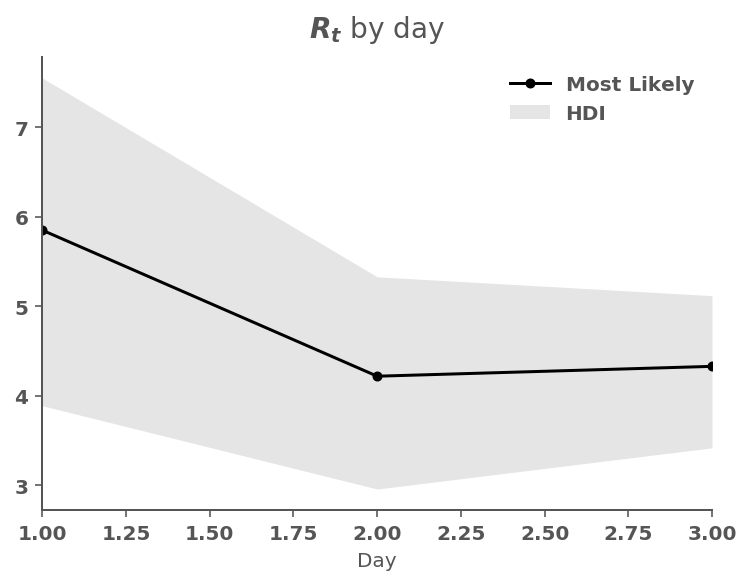

In [16]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title='$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

We can see that the most likely value of $R_t$ changes with time and the highest-density interval narrows as we become more sure of the true value of $R_t$ over time. Note that since we only had four days of history, I did not apply the gaussian process to this sample. Next, however, we'll turn to a real-world application where this process is necessary.

# Real-World Application to US Data

### Setup

Load US state case data from the NYT archive

In [98]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states = pd.read_csv(url,
                     usecols=[0,1,3],
                     index_col=['state', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()

Taking a look at the state, we need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

In [123]:
state_name = 'New York'

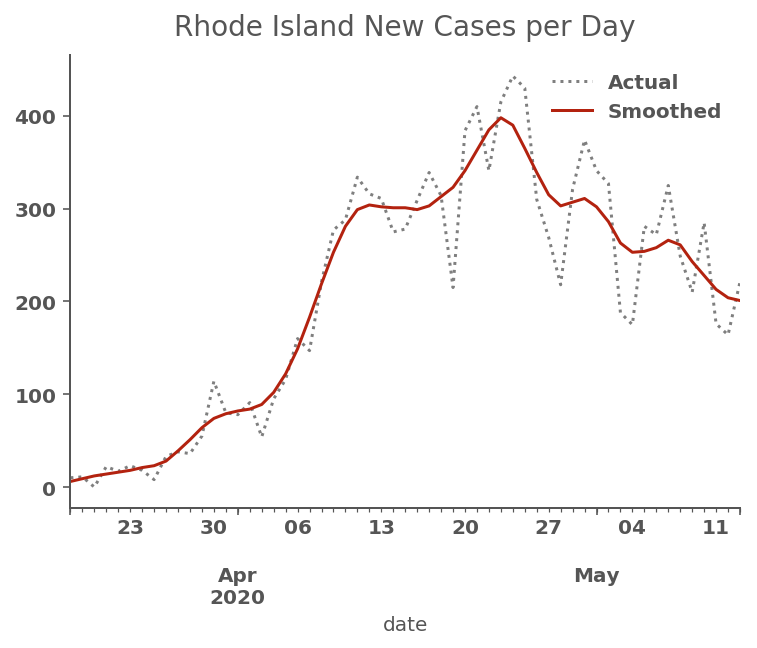

In [201]:
def prepare_cases(cases, cutoff=25):
    new_cases = cases.diff()

    smoothed_new_cases = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    # issues with negative values -- my fix: should probably make a PR
    smoothed_new_cases[smoothed_new_cases < 0] = float(0)
    
    # only include data after cutoff total cases
    idx_start = np.searchsorted(cases, cutoff)
    
    cum_cases = cases.iloc[idx_start:].rename('cumulative_cases')
    new_cases = new_cases.iloc[idx_start:].rename('new_cases')
    smoothed_new_cases = smoothed_new_cases.iloc[idx_start:].rename('smoothed_new_cases')
    return cum_cases, new_cases, smoothed_new_cases

cases = states.xs(state_name).rename("%s cases" % state_name)

cum_cases, new_cases, smoothed_new_cases = prepare_cases(cases)
state_result = pd.concat([cum_cases, new_cases, smoothed_new_cases], axis=1)

state_result['new_cases'].plot(title="%s New Cases per Day" % state_name,
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = state_result['smoothed_new_cases'].plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

### Running the Algorithm

Choosing the Gaussian $\sigma$ for $P(R_t|R_{t-1})$

>Note: you can safely skip this section if you trust that we chose the right value of $\sigma$ for the process below. Otherwise, read on.

The original approach simply selects yesterday's posterior as today's prior. While intuitive, doing so doesn't allow for our belief that the value of $R_t$ has likely changed from yesterday. To allow for that change, we apply Gaussian noise to the prior distribution with some standard deviation $\sigma$. The higher $\sigma$ the more noise and the more we will expect the value of $R_t$ to drift each day. Interestingly, applying noise on noise iteratively means that there will be a natural decay of distant posteriors. This approach has a similar effect of windowing, but is more robust and doesn't arbitrarily forget posteriors after a certain time like my previous approach. Specifically, windowing computed a fixed $R_t$ at each time $t$ that explained the surrounding $w$ days of cases, while the new approach computes a series of $R_t$ values that explains all the cases, assuming that $R_t$ fluctuates by about $\sigma$ each day.

However, there's still an arbitrary choice: what should $\sigma$ be? Adam Lerer pointed out that we can use the process of maximum likelihood to inform our choice. Here's how it works:

Maximum likelihood says that we'd like to choose a $\sigma$ that maximizes the likelihood of seeing our data $k$: $P(k|\sigma)$. Since $\sigma$ is a fixed value, let's leave it out of the notation, so we're trying to maximize $P(k)$ over all choices of $\sigma$.

Since $P(k)=P(k_0,k_1,\ldots,k_t)=P(k_0)P(k_1)\ldots P(k_t)$ we need to define $P(k_t)$. It turns out this is the denominator of Bayes rule:

$$P(R_t|k_t) = \frac{P(k_t|R_t)P(R_t)}{P(k_t)}$$
To calculate it, we notice that the numerator is actually just the joint distribution of $k$ and $R$:

$$ P(k_t,R_t) =  P(k_t|R_t)P(R_t) $$
We can marginalize the distribution over $R_t$ to get $P(k_t)$:

$$ P(k_t) = \sum_{R_{t}}{P(k_t|R_t)P(R_t)} $$
So, if we sum the distribution of the numerator over all values of $R_t$, we get $P(k_t)$. And since we're calculating that anyway as we're calculating the posterior, we'll just keep track of it separately.

Since we're looking for the value of $\sigma$ that maximizes $P(k)$ overall, we actually want to maximize:

$$\prod_{t,i}{p(k_{ti})}$$
where $t$ are all times and $i$ is each state.

Since we're multiplying lots of tiny probabilities together, it can be easier (and less error-prone) to take the $\log$ of the values and add them together. Remember that $\log{ab}=\log{a}+\log{b}$. And since logarithms are monotonically increasing, maximizing the sum of the $\log$ of the probabilities is the same as maximizing the product of the non-logarithmic probabilities for any choice of $\sigma$.

### Function for Calculating the Posteriors
To calculate the posteriors we follow these steps:

1. Calculate $\lambda$ - the expected arrival rate for every day's poisson process
2. Calculate each day's likelihood distribution over all possible values of $R_t$
3. Calculate the process matrix based on the value of $\sigma$ we discussed above
4. Calculate our initial prior because our first day does not have a previous day from which to take the posterior
  - Based on info from the cdc we will choose a Gamma with mean 7.
5. Loop from day 1 to the end, doing the following:
  - Calculate the prior by applying the Gaussian to yesterday's prior.
  - Apply Bayes' rule by multiplying this prior and the likelihood we calculated in step 2.
  - Divide by the probability of the data (also Bayes' rule)

In [125]:
def get_posteriors(sr, sigma=0.25):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None])

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)

    
    # (4) Calculate the initial prior
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):
        #(5a) Calculate the new prior
        current_prior = np.dot(process_matrix,posteriors[previous_day])
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood
    

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

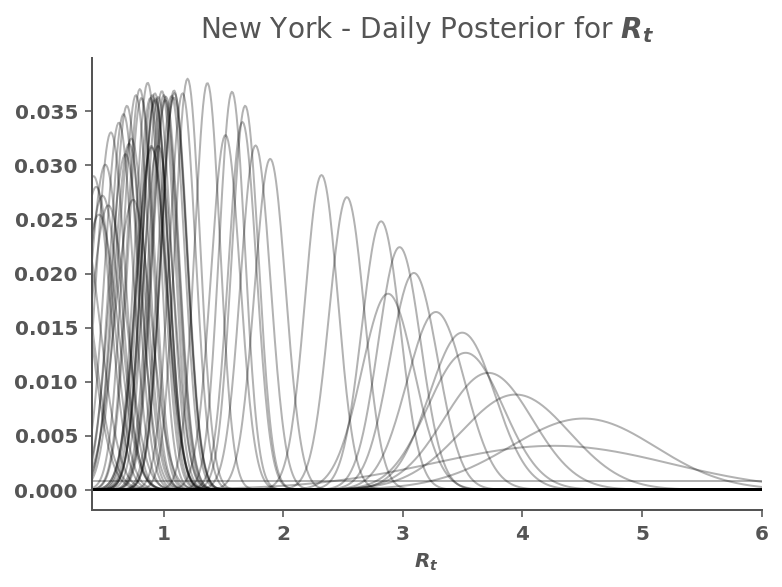

In [126]:
ax = posteriors.plot(title='%s - Daily Posterior for $R_t$' % state_name,
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [127]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

ML  Low_90  High_90
state      date                             
New Jersey 2020-05-09  0.54    0.28     0.78
           2020-05-10  0.46    0.17     0.69
           2020-05-11  0.31    0.04     0.54
           2020-05-12  0.21    0.00     0.45
           2020-05-13  0.22    0.00     0.47

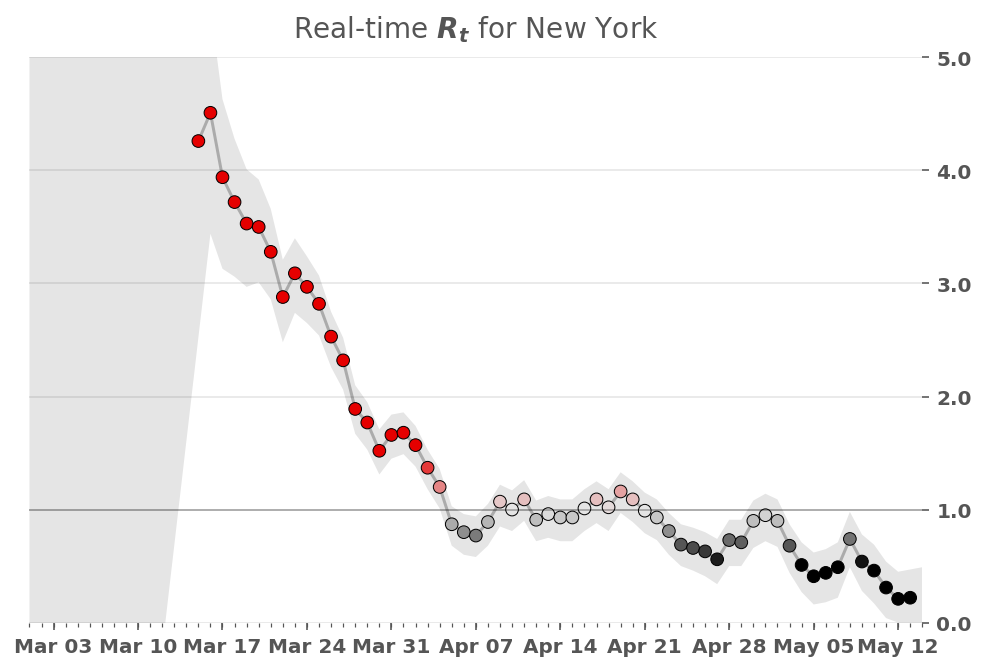

In [128]:
def plot_rt(result, ax, title):
    
    ax.set_title(title) #
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_title ='Real-time $R_t$ for %s' % state_name
plot_rt(result.iloc[1:], ax, plot_title)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Repeat the Process for Every State

In [136]:
states_results = {}

states_to_process = states.loc[~states.index.get_level_values('state').isin(FILTERED_REGIONS)]

grouped_states_to_process = states_to_process.groupby(level='state')
for i, (state_name, cases) in enumerate(grouped_states_to_process):
    clear_output(wait=True)
    
    print('%s/%s Processing %s' % (str(i+1), len(grouped_states_to_process), state_name))
    cum_cases, new_cases, smoothed_new_cases = prepare_cases(cases, cutoff=25)
    if len(smoothed_new_cases) == 0:
        cum_cases, new_cases, smoothed_new_cases = prepare_cases(cases, cutoff=10)
    print('\tGetting Posteriors')
    try:
        posteriors, p_data = get_posteriors(smoothed_new_cases)
    except:
        display(new_cases)
    print('\tGetting HDIs')
    hdis_90 = highest_density_interval(posteriors, p=.9)
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, cum_cases, new_cases, smoothed_new_cases], axis=1)
    states_results[state_name] = result.droplevel(0)[1:]
    
# clear_output(wait=True)
print('Done.')

51/51 Processing Wyoming
	Getting Posteriors
	Getting HDIs
	Getting most likely values
Done.


### Plot All US States

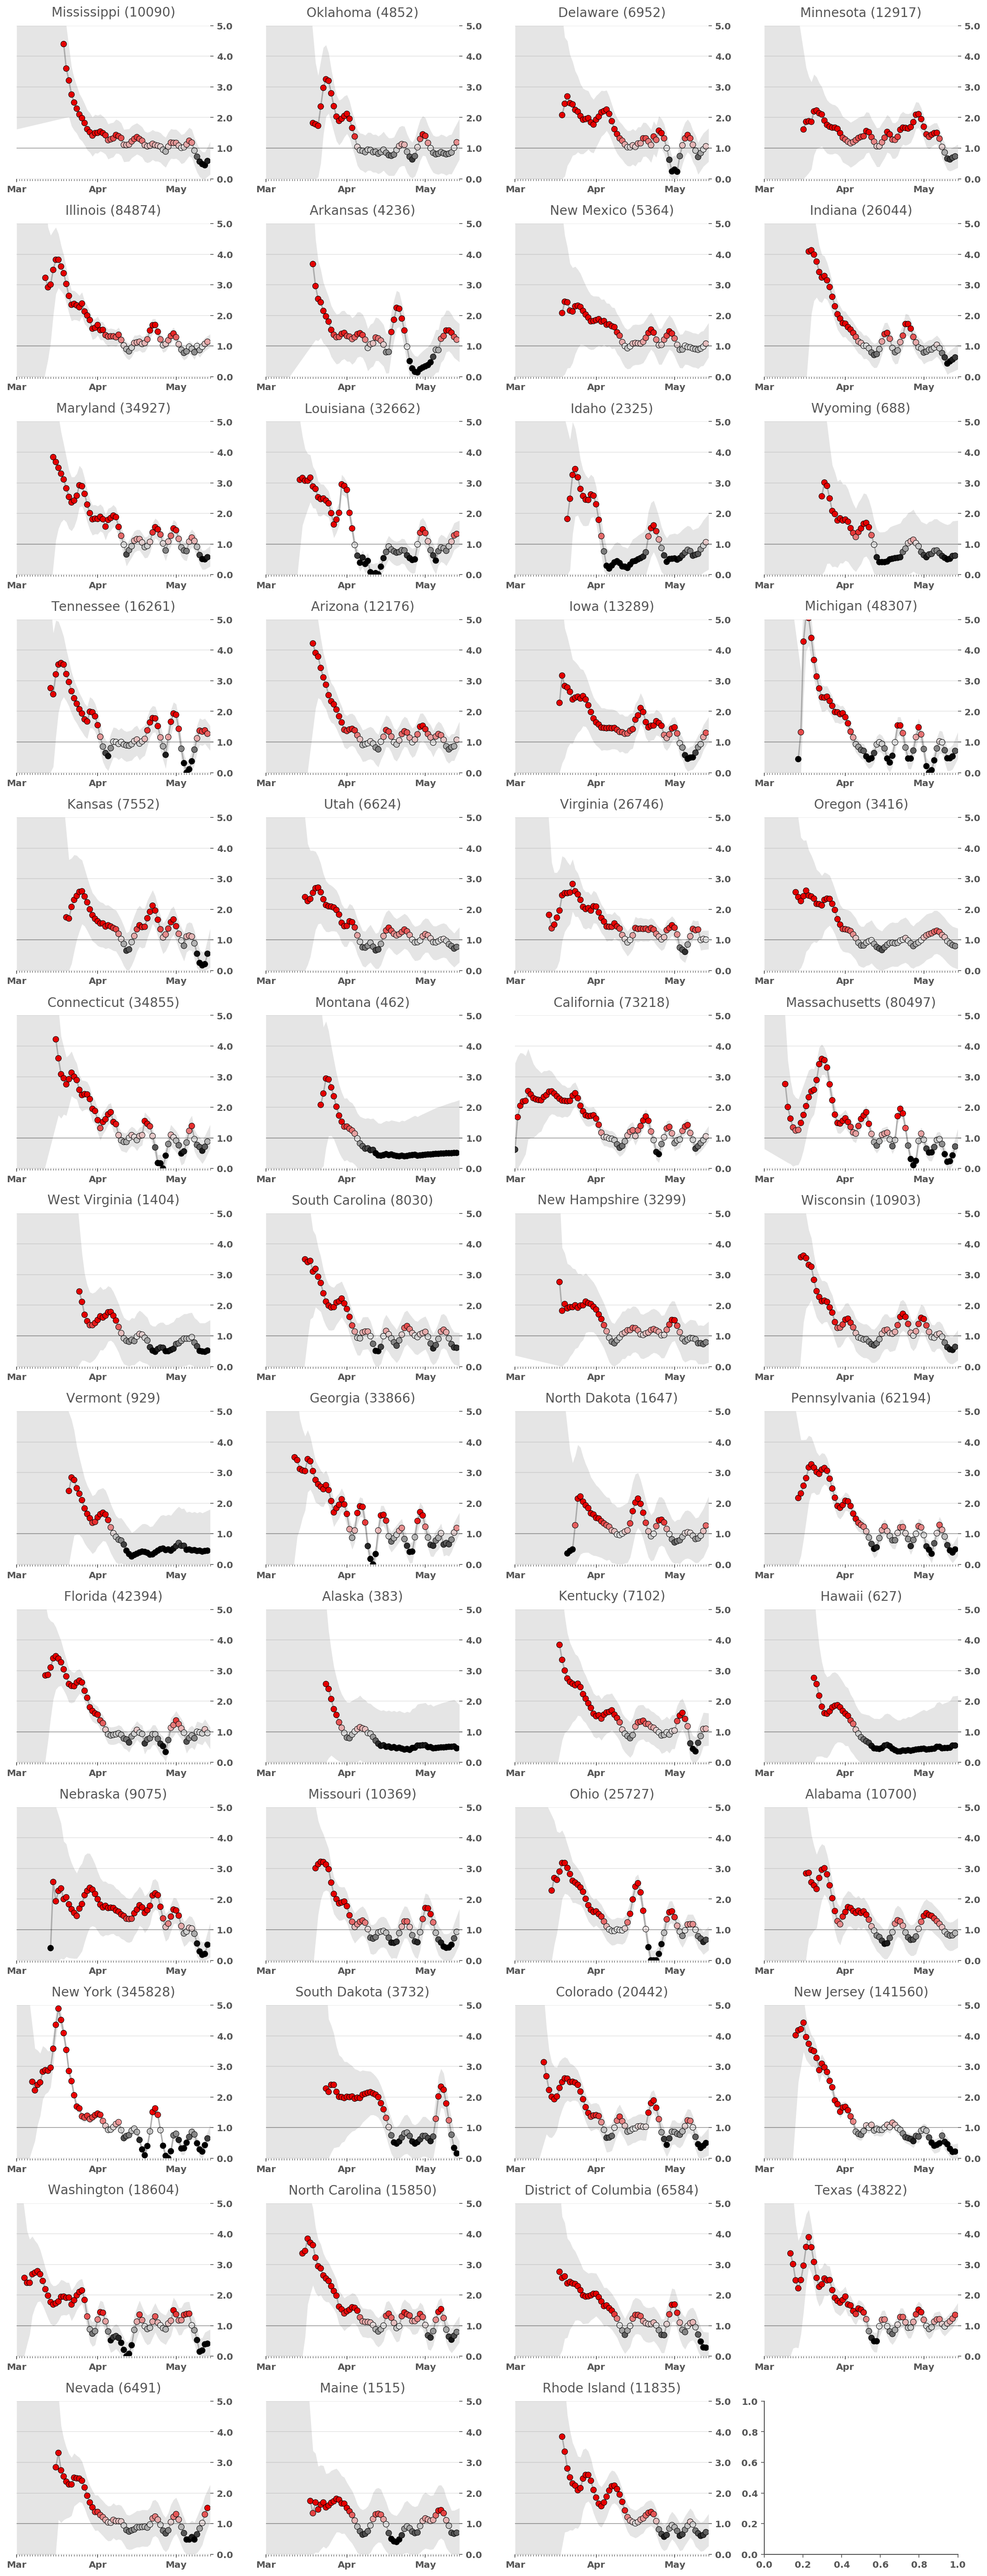

In [137]:
ncols = 4
nrows = int(np.ceil(len(states_results) / ncols)) + 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(states_results.items()):
    cumulative_cases = result.iloc[-1]['cumulative_cases']
    plot_title = '%s (%s)' % (state_name, str(int(cumulative_cases)))
    plot_rt(result, axes.flat[i], plot_title)

fig.tight_layout()
fig.set_facecolor('w')

### Export Data to CSV

In [138]:
states_overall_rt_fname = './data/states_rt.csv'

In [139]:
states_overall = None

for state_name, result in states_results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[state_name], result.index], names=['state', 'date'])
    if states_overall is None:
        states_overall = r
    else:
        states_overall = pd.concat([states_overall, r])

states_overall.sort_index(inplace=True)
states_overall.head()

ML  Low_90  High_90  cumulative_cases  new_cases  \
state   date                                                             
Alabama 2020-03-17  2.84    0.09     5.20                39       10.0   
        2020-03-18  2.86    0.71     4.74                51       12.0   
        2020-03-19  2.55    0.85     4.10                78       27.0   
        2020-03-20  2.45    0.98     3.74               106       28.0   
        2020-03-21  2.33    1.05     3.46               131       25.0   

                    smoothed_new_cases  
state   date                            
Alabama 2020-03-17                13.0  
        2020-03-18                17.0  
        2020-03-19                20.0  
        2020-03-20                24.0  
        2020-03-21                28.0

In [140]:
print('saving states Rt data to %s' % states_overall_rt_fname)
states_overall.to_csv(states_overall_rt_fname)

saving states Rt data to ./data/states_rt.csv


### Read Data from CSV

(For returning to script)

In [ ]:
states_overall = pd.read_csv(states_overall_rt_fname, index_col='state')
states_overall.head()

# Counties

That was a nice introduction! Thanks! Now let's try this with counties data.

In particular, counties in the NY Metro area.


Moving forward to later compare to contacts data, use this notebook as reference: https://github.com/michielbakker/social-distance/blob/master/notebooks/contacts_vs_reported_cases_by_county.ipynb

In [257]:
STATE_COUNTY_ID = 'state_county_id'

NEW_YORK_CITY = 'New York City'

In [258]:
counties_cases_data_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

all_counties_cases_df = pd.read_csv(counties_cases_data_url,
                     usecols=[0,1,2,3,4,5],
                     parse_dates=['date'],
                     squeeze=True).sort_index()

all_counties_cases_df.sort_values('date', ascending=False).head(3)

date    county     state     fips  cases  deaths
144325 2020-05-14  Washakie   Wyoming  56043.0      7       0
142384 2020-05-14    Harlan  Kentucky  21095.0      1       0
142382 2020-05-14   Hancock  Kentucky  21091.0      7       0

subset data to NY metro area

Get MSA / County FIPs code data. It's from: https://www.census.gov/geographies/reference-files/time-series/demo/metro-micro/delineation-files.html

In [143]:
fips_filepath = './data/cbsa-msa-county-state-fips-2018.csv'

fips_df = pd.read_csv(fips_filepath, usecols=[3,9,10])
cbsa_fips = fips_df[fips_df['CBSA Title'] == 'New York-Newark-Jersey City, NY-NJ-PA']
# there are 23 counties in New York Metro area according to Wikipedia: https://en.wikipedia.org/wiki/New_York_metropolitan_area
assert(cbsa_fips.shape[0] == 23)

cbsa_fips.head(3)

CBSA Title  FIPS State Code  FIPS County Code
1205  New York-Newark-Jersey City, NY-NJ-PA             36.0              59.0
1206  New York-Newark-Jersey City, NY-NJ-PA             36.0             103.0
1207  New York-Newark-Jersey City, NY-NJ-PA             34.0              13.0

In [144]:
# get the counties fips
# STATE+COUNTY = 2+3=5
COUNTY_FIPS_CODE = 'full county fips code'
metro_area_county_fips = cbsa_fips['FIPS State Code'].apply(lambda x: str(int(x)).zfill(2)) + cbsa_fips['FIPS County Code'].apply(lambda x: str(int(x)).zfill(3))
metro_area_county_fips = metro_area_county_fips.astype('float64')

Just keep  the  counties  data for NY metro area

New York City counties (New York, Kings, Queens, Bronx and Richmond) were combined.

In [145]:
# Just keep  the  counties  data for NY metro area
ny_counties_cases_df = all_counties_cases_df[\
    (all_counties_cases_df['fips'].isin(metro_area_county_fips)) \
     | (all_counties_cases_df['county']=='New York City')]

# index by county,  date
ny_counties_cases_df = ny_counties_cases_df.sort_values('county').set_index(['county','date']).sort_index()
ny_counties_cases_df.head()

state     fips  cases  deaths
county date                                          
Bergen 2020-03-04  New Jersey  34003.0      1       0
       2020-03-05  New Jersey  34003.0      2       0
       2020-03-06  New Jersey  34003.0      3       0
       2020-03-07  New Jersey  34003.0      3       0
       2020-03-08  New Jersey  34003.0      4       0

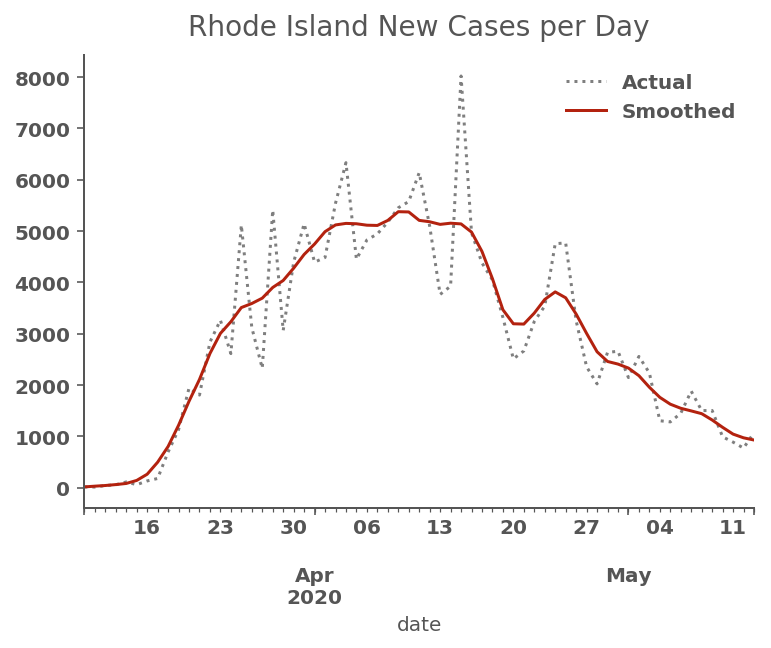

In [146]:
name = 'New York City'

cases = ny_counties_cases_df.xs(name)['cases']


cum_cases, new_cases, smoothed_new_cases = prepare_cases(cases)
c_result = pd.concat([cum_cases, new_cases, smoothed_new_cases], axis=1)

c_result['new_cases'].plot(title="%s New Cases per Day" % state_name,
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = c_result['smoothed_new_cases'].plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

### Plot RT

In [151]:
posteriors, p_data = get_posteriors(c_result['smoothed_new_cases'])
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
ny_result = pd.concat([most_likely, hdis, c_result['cumulative_cases']], axis=1)
ny_result = ny_result.iloc[1:]
ny_result.head()

trying for p=0.89
trying for p=0.88


ML  Low_90  High_90  cumulative_cases
date                                               
2020-03-11  5.03    2.86     6.95                52
2020-03-12  4.01    2.60     5.25                96
2020-03-13  3.69    2.66     4.66               155
2020-03-14  3.43    2.59     4.22               269
2020-03-15  4.00    3.30     4.64               330

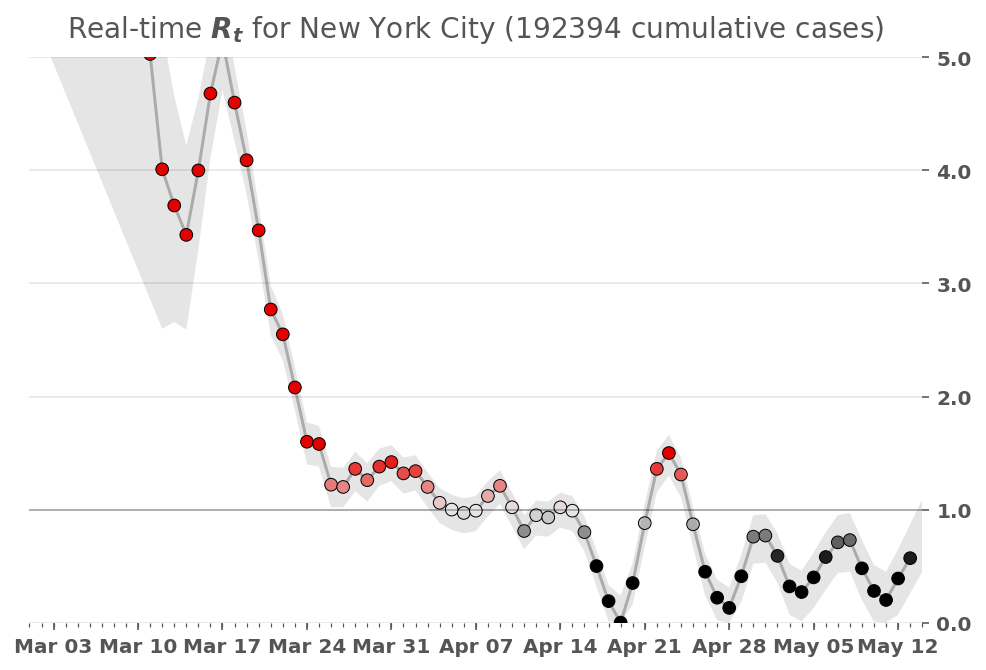

In [157]:
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(ny_result, ax, name)
ax.set_title('Real-time $R_t$ for %s (%s cumulative cases)' % (name, c_result['cumulative_cases'][-1]))
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Repeat the process for every county

In [161]:
county_results = {}

counties_to_process = ny_counties_cases_df
grouped_counties_to_process = counties_to_process.groupby(level='county')

for i, (name, data) in enumerate(grouped_counties_to_process):
    clear_output(wait=True)
    print('%s/%s Processing %s' % (str(i+1), len(grouped_counties_to_process), name))
    cum_cases, new_cases, smoothed_new_cases = prepare_cases(data['cases'], cutoff=25)
    print('\tGetting Posteriors')
    try:
        posteriors, p_data = get_posteriors(smoothed_new_cases)
    except:
        display(cases)
    print('\tGetting HDIs')
    hdis_90 = highest_density_interval(posteriors, p=.9)
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, cum_cases, new_cases, smoothed_new_cases], axis=1)
    county_results[name] = result.droplevel(0)[1:]
    
# clear_output(wait=True)
print('Done.')

19/19 Processing Westchester
	Getting Posteriors
	Getting HDIs
	Getting most likely values
Done.


### Plot All NY metro area counties

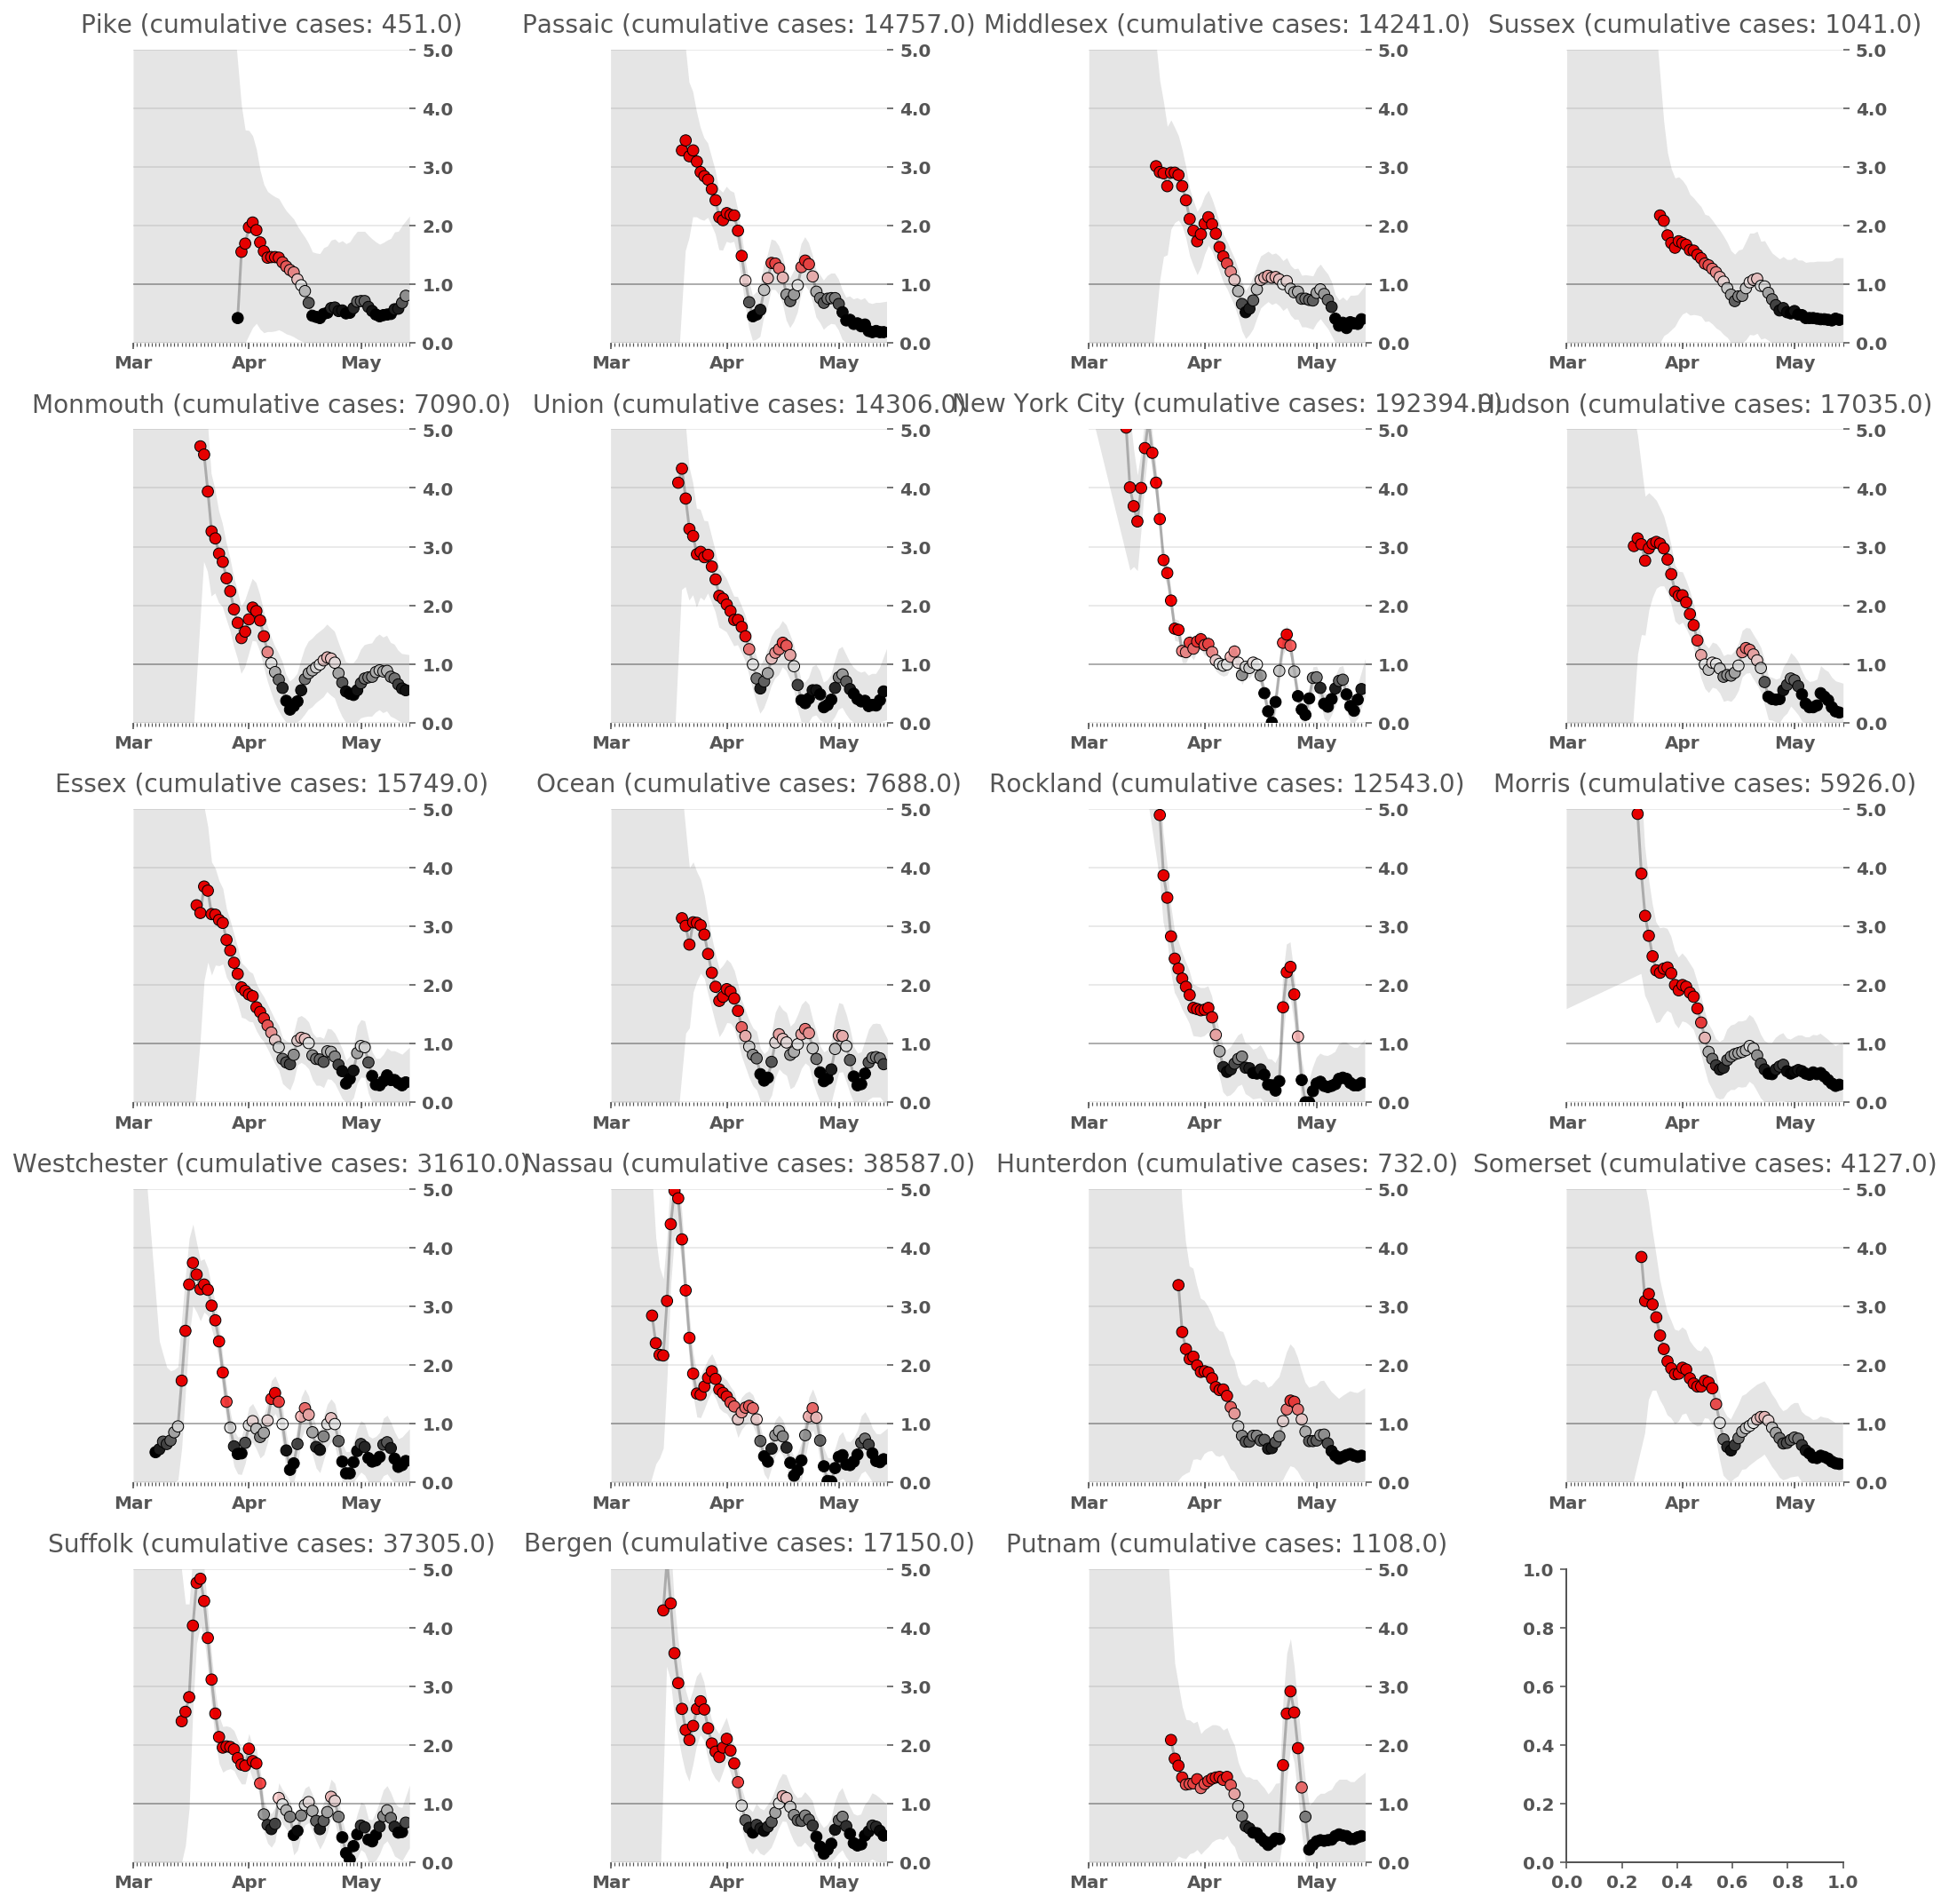

In [162]:
ncols = 4
nrows = int(np.ceil(len(county_results) / ncols)) + 1

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (name, result) in enumerate(county_results.items()):
    cumulative_cases = result.iloc[-1]['cumulative_cases']
    plot_title = '%s (cumulative cases: %s)' % (name, str(cumulative_cases))
    plot_rt(result, axes.flat[i], plot_title)

fig.tight_layout()
fig.set_facecolor('w')

### Export Data to CSV


In [163]:
ny_counties_rts_fname = './data/ny_counties_rt.csv'

In [164]:
ny_counties_rts = None

for name, result in county_results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[name], result.index], names=['county', 'date'])
    if ny_counties_rts is None:
        ny_counties_rts = r
    else:
        ny_counties_rts = pd.concat([ny_counties_rts, r])

ny_counties_rts.sort_index(inplace=True)

# Uncomment this line if you'd like to export
print('saving NY counties Rt data to %s' % ny_counties_rts_fname)
ny_counties_rts.to_csv(ny_counties_rts_fname)
ny_counties_rts.head()

saving NY counties Rt data to ./data/ny_counties_rt.csv


ML  Low_90  High_90  cumulative_cases  new_cases  \
county date                                                             
Bergen 2020-03-15  4.29    1.21     6.80                32        1.0   
       2020-03-16  5.15    3.33     6.72                61       29.0   
       2020-03-17  4.41    3.11     5.54                84       23.0   
       2020-03-18  3.56    2.53     4.48               133       49.0   
       2020-03-19  3.05    2.15     3.83               297      164.0   

                   smoothed_new_cases  
county date                            
Bergen 2020-03-15                16.0  
       2020-03-16                31.0  
       2020-03-17                46.0  
       2020-03-18                57.0  
       2020-03-19                68.0

### Read data from CSV

(Re-entry for notebook)

In [256]:
ny_counties_rts = pd.read_csv(ny_counties_rts_fname,
                     index_col=['county', 'date'],
                     parse_dates=['date']).sort_index()
ny_counties_rts.head()

ML  Low_90  High_90  cumulative_cases  new_cases  \
county date                                                             
Bergen 2020-03-15  4.29    1.21     6.80                32        1.0   
       2020-03-16  5.15    3.33     6.72                61       29.0   
       2020-03-17  4.41    3.11     5.54                84       23.0   
       2020-03-18  3.56    2.53     4.48               133       49.0   
       2020-03-19  3.05    2.15     3.83               297      164.0   

                   smoothed_new_cases  
county date                            
Bergen 2020-03-15                16.0  
       2020-03-16                31.0  
       2020-03-17                46.0  
       2020-03-18                57.0  
       2020-03-19                68.0

### Smell check!

Check: Is data availability too much of a problem for this Rt algorithm at this point in reporting  history?

Is the number of cumulative cases closely correlated with Rt?


In [167]:
ny_counties_mr = ny_counties_rts.groupby(level=0)[
    ['ML','Low_90','High_90','cumulative_cases','new_cases','smoothed_new_cases']
].last()
ny_counties_mr.head(3)

ML  Low_90  High_90  cumulative_cases  new_cases  smoothed_new_cases
county                                                                        
Bergen  0.45     0.0     1.03             17150       59.0                76.0
Essex   0.34     0.0     0.88             15749       91.0                85.0
Hudson  0.17     0.0     0.69             17035       60.0                75.0

(<Figure size 720x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0ffdbd3dd0>)

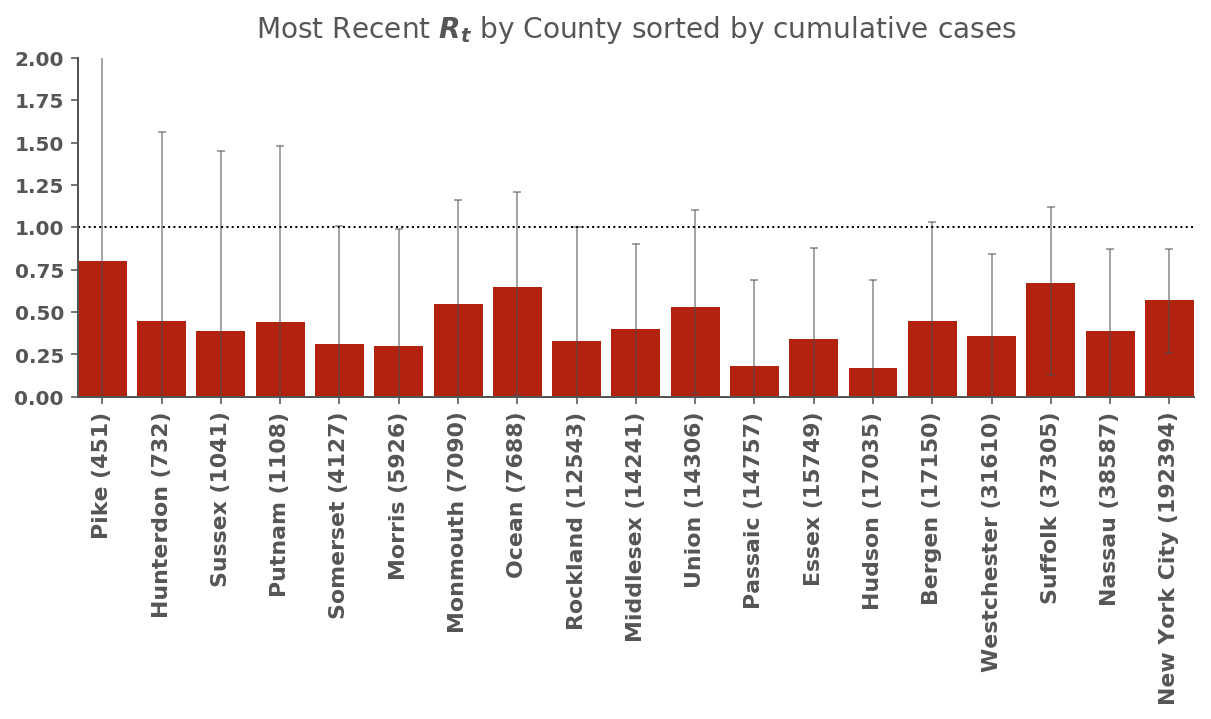

In [173]:
ERROR_BAR_COLOR = [.3,.3,.3]
FULL_COLOR = [.7,.7,.7]

def plot_local_standings(mr, figsize=None, title='Most Recent $R_t$ by County'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                # color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    labels = ny_counties_mr.reset_index().apply(lambda row: '%s (%s)'%(str(row['county']),str(row['cumulative_cases'])), axis=1)# + '(%s)'%row[cases])

    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    fig.set_facecolor('w')
    return fig, ax

ny_counties_mr.sort_values('cumulative_cases', inplace=True)

plot_local_standings(ny_counties_mr,
                     figsize=(10,3),
                     title='Most Recent $R_t$ by County sorted by cumulative cases')


### Question: What would this  data look like if we were using  deaths instead of reported cases as an indicator for Rt?



In [181]:
ny_counties_cases_df.head()

state     fips  cases  deaths
county date                                          
Bergen 2020-03-04  New Jersey  34003.0      1       0
       2020-03-05  New Jersey  34003.0      2       0
       2020-03-06  New Jersey  34003.0      3       0
       2020-03-07  New Jersey  34003.0      3       0
       2020-03-08  New Jersey  34003.0      4       0

In [182]:
county_names = county_results.keys()

In [183]:
def plot_cases_deaths(cases, deaths, ax, title):
    ax.set_title(title)
    
    original_cases, new, smoothed = prepare_cases(cases, cutoff=10)
    original_deaths, new_deaths, smoothed_deaths = prepare_cases(deaths, cutoff=10)
    
    # plot deaths in red
    ax.plot(original_deaths.index, original_deaths.values,
        c='red',
        linestyle=':',
        alpha=.5,
        label='Deaths: Actual',
        )
    
    ax.plot(smoothed_deaths.index, smoothed_deaths.values,
        c='red',
        label='Deaths: Smoothed',
        )
    # plot cases in red
    ax.plot(original_cases.index, original_cases.values,
       c='blue',
       linestyle=':',
       alpha=.5,
       label='Cases: Actual',
   )
    
    ax.plot(smoothed.index, smoothed.values,
       c='blue',
        label='Cases: Smoothed',
    )

    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)

    ax.get_figure().set_facecolor('w')

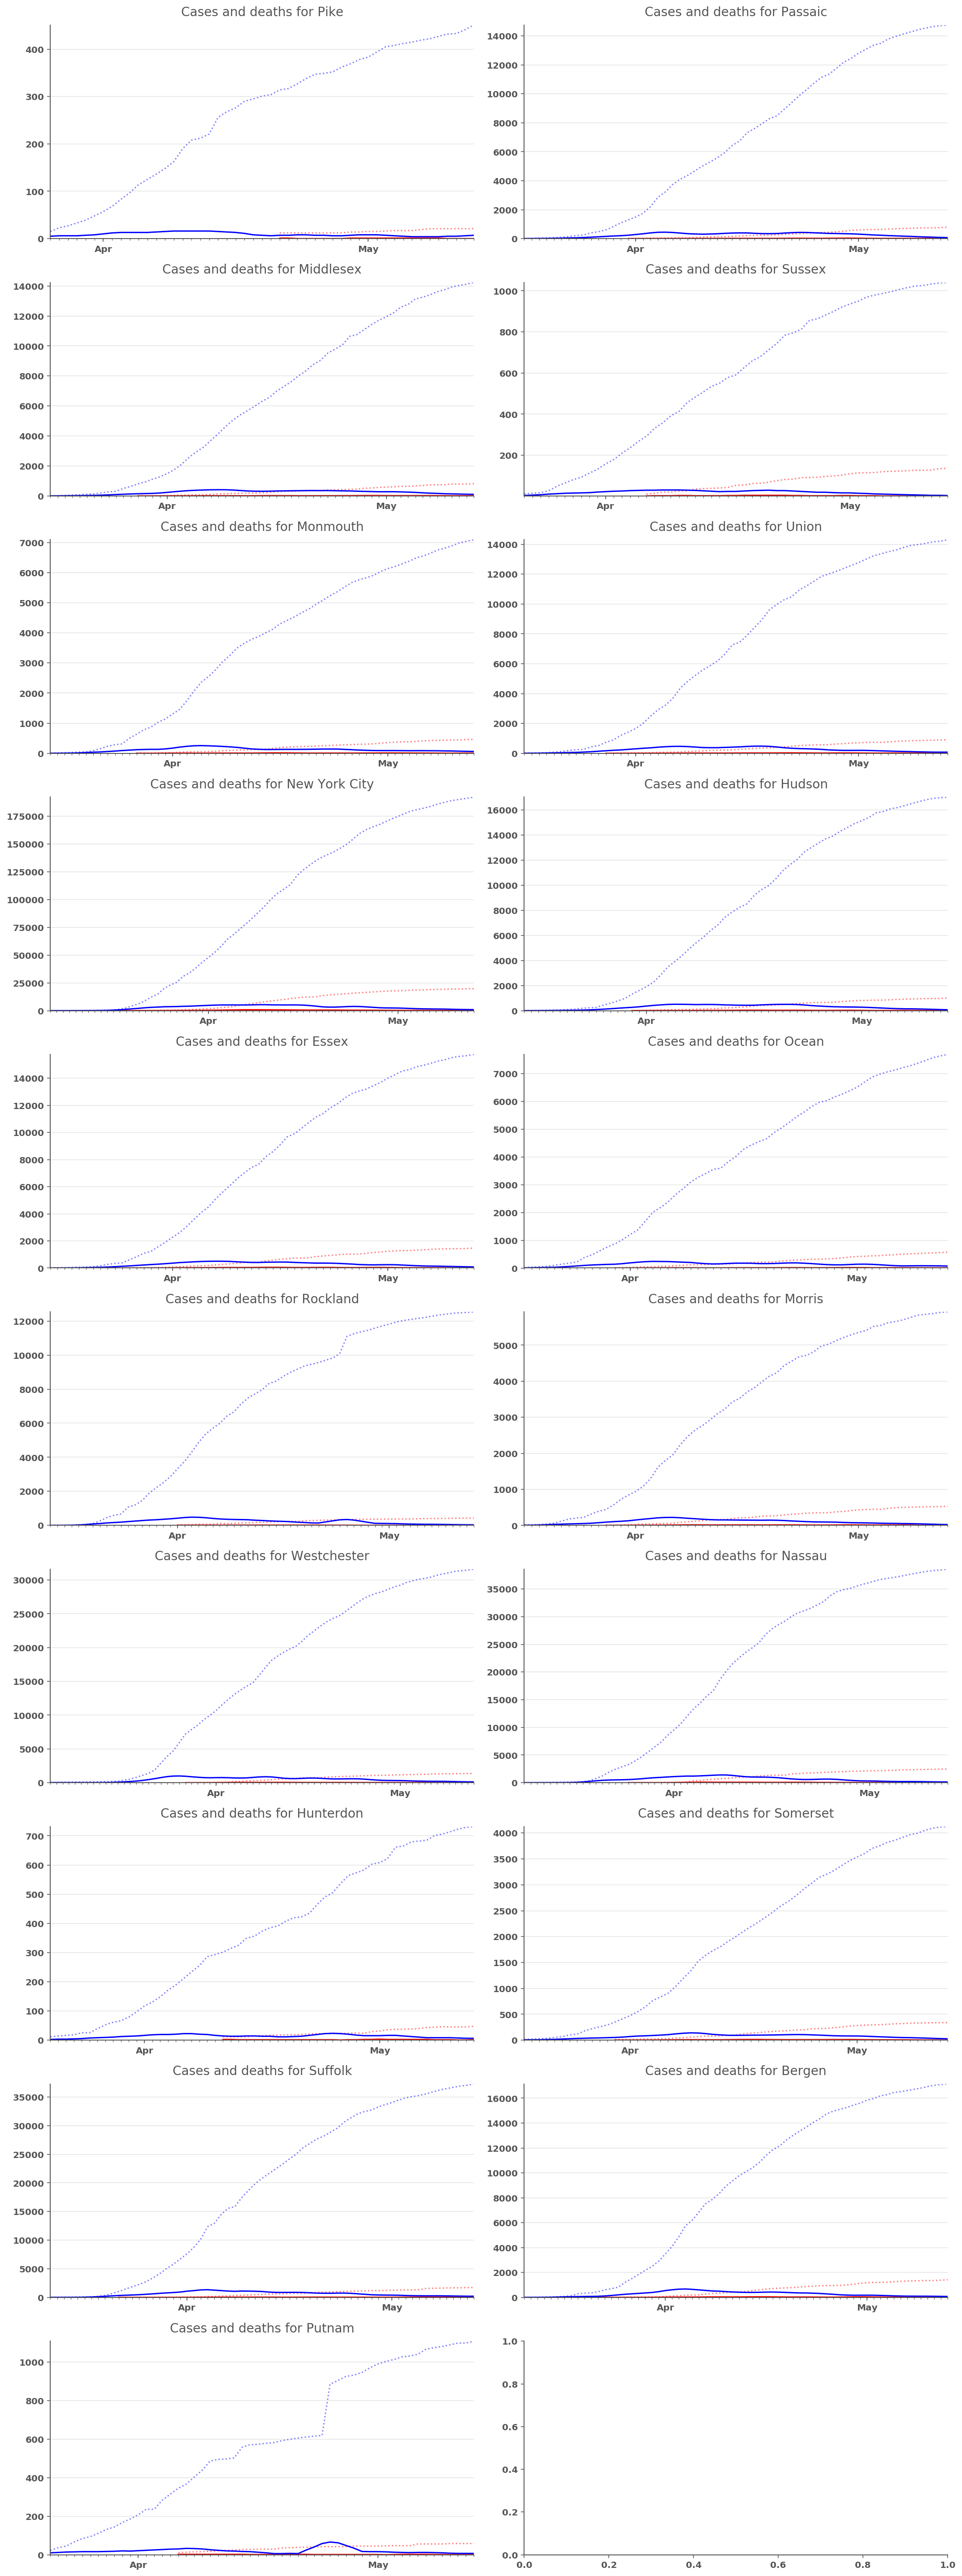

In [184]:
ncols = 2
nrows = int(np.ceil(len(county_results) / ncols)) + 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*4))

for i, name in enumerate(county_names):
    cases = ny_counties_cases_df.xs(name)['cases']
    deaths = ny_counties_cases_df.xs(name)['deaths']
    plot_title = 'Cases and deaths for %s' % name
    plot_cases_deaths(cases, deaths, axes.flat[i], plot_title)

fig.tight_layout()
fig.set_facecolor('w')


## Compute realtime reproductive number for each county in  each of our areas


get the county FIPs for each metro area  from the user panel

In [186]:
metro_areas_names = [
    'washington',
    'seattle',
    'miami',
    'LA',
    'houston',
    'boston',
    'dallas',
    'chicago',
    'NY',
    'philadelphia'
]

datapath = '/data/covid/'

metro_areas_names_fpaths = {m: '{}{}/'.format(datapath,m) for m in metro_areas_names}
metro_areas_names_fpaths['NY'] = datapath
metro_areas_names_fpaths

{'LA': '/data/covid/LA/',
 'NY': '/data/covid/',
 'boston': '/data/covid/boston/',
 'chicago': '/data/covid/chicago/',
 'dallas': '/data/covid/dallas/',
 'houston': '/data/covid/houston/',
 'miami': '/data/covid/miami/',
 'philadelphia': '/data/covid/philadelphia/',
 'seattle': '/data/covid/seattle/',
 'washington': '/data/covid/washington/'}

In [187]:
# We save the RT data to '/data/covid/AREA/AREA_counties_rt.csv'
county_rts_fnames = {m: '{}{}_counties_rt.csv'.format(fpath, m) for m, fpath in metro_areas_names_fpaths.items()}
county_rts_fnames

{'LA': '/data/covid/LA/LA_counties_rt.csv',
 'NY': '/data/covid/NY_counties_rt.csv',
 'boston': '/data/covid/boston/boston_counties_rt.csv',
 'chicago': '/data/covid/chicago/chicago_counties_rt.csv',
 'dallas': '/data/covid/dallas/dallas_counties_rt.csv',
 'houston': '/data/covid/houston/houston_counties_rt.csv',
 'miami': '/data/covid/miami/miami_counties_rt.csv',
 'philadelphia': '/data/covid/philadelphia/philadelphia_counties_rt.csv',
 'seattle': '/data/covid/seattle/seattle_counties_rt.csv',
 'washington': '/data/covid/washington/washington_counties_rt.csv'}

In [188]:
# get the counties for each  metro area by the unique counties from user panel

def geoid_to_county_id(geoid):
    return str(geoid)[:5]

def get_county_fips(metro_area_fpath):
    homes_fpath = metro_area_fpath+'homes.final.txt'
    data_panel_df = pd.read_csv(homes_fpath, dtype={'GEOID':'str'}) # do not read GEOID in as int because it strips off leading zero
    return list(data_panel_df['GEOID'].apply(geoid_to_county_id).unique())
    

In [189]:
metro_areas_county_fips = {}

for name, fpath in metro_areas_names_fpaths.items():
    print('getting counties for metro area: %s'% name)
    try:
        fips = get_county_fips(fpath)
        metro_areas_county_fips[name] = fips
    except Exception as e:
        print('error getting county data for %s' % name)
        print(e)

getting counties for metro area: houston
error getting county data for houston
[Errno 2] File /data/covid/houston/homes.final.txt does not exist: '/data/covid/houston/homes.final.txt'
getting counties for metro area: LA
getting counties for metro area: miami
getting counties for metro area: boston
getting counties for metro area: dallas
getting counties for metro area: washington
getting counties for metro area: philadelphia
error getting county data for philadelphia
[Errno 2] File /data/covid/philadelphia/homes.final.txt does not exist: '/data/covid/philadelphia/homes.final.txt'
getting counties for metro area: NY
getting counties for metro area: seattle
getting counties for metro area: chicago


In [190]:
# Handle that the NY Times data source combines the New York City counties data

NYC = 'New York City'
NYC_FIPS = '99999'

metro_areas_county_fips['NY'] = metro_areas_county_fips['NY'] + [NYC_FIPS]

all_counties_cases_df.loc[(all_counties_cases_df['county'] == NYC), 'fips'] = NYC_FIPS
all_counties_cases_df[all_counties_cases_df['county'] == 'New York City'].head()

date         county     state   fips  cases  deaths
416 2020-03-01  New York City  New York  99999      1       0
448 2020-03-02  New York City  New York  99999      1       0
482 2020-03-03  New York City  New York  99999      2       0
518 2020-03-04  New York City  New York  99999      2       0
565 2020-03-05  New York City  New York  99999      4       0

In [191]:
metro_areas_county_fips

{'LA': ['06059', '06037'],
 'NY': ['34035',
  '34025',
  '34037',
  '34019',
  '36081',
  '34003',
  '36005',
  '36059',
  '36047',
  '36085',
  '36103',
  '34013',
  '36071',
  '36061',
  '34017',
  '36087',
  '34031',
  '34029',
  '34023',
  '34027',
  '36119',
  '36079',
  '34039',
  '42103',
  '99999'],
 'boston': ['25017', '25009', '25023', '25025', '33015', '25021', '33017'],
 'chicago': ['17031',
  '17043',
  '17197',
  '17111',
  '17093',
  '17097',
  '18089',
  '17089',
  '18127',
  '17037',
  '55059',
  '18073',
  '17063',
  '18111'],
 'dallas': ['48121',
  '48113',
  '48439',
  '48251',
  '48085',
  '48367',
  '48139',
  '48257',
  '48231',
  '48397',
  '48221',
  '48497',
  '48425'],
 'miami': ['12011', '12086', '12099'],
 'seattle': ['53053', '53033', '53061'],
 'washington': ['24033',
  '51059',
  '51107',
  '51061',
  '11001',
  '51510',
  '51153',
  '51179',
  '24031',
  '24021',
  '51177',
  '24017',
  '51600',
  '54037',
  '51047',
  '51013',
  '51683',
  '24009',
  '

In [192]:
def fips_str(fips):
    try:
        return str(int(float(fips))).zfill(5)
    except:
        return fips

assert(fips_str('06059') == '06059')
assert(fips_str(NYC_FIPS) == NYC_FIPS)

In [193]:
all_counties_cases_df['fips'] = all_counties_cases_df['fips'].apply(fips_str)

In [273]:
metro_area_county_results = {}

for metro_area, county_fips in metro_areas_county_fips.items():

    counties_cases_df = all_counties_cases_df[all_counties_cases_df['fips'].isin(county_fips)]
    # index by FIPS, date
    # important to use FIPs because County name repeats across States, and sometimes  within same metro area
    # e.g. there is a Lake IL and Lake IN, both in Chicago metro area
    counties_cases_df = counties_cases_df.sort_values('fips').set_index(['fips','date']).sort_index()
    
    county_results = {}

    counties_to_process = counties_cases_df
    grouped_counties_to_process = counties_to_process.groupby(level='fips')

    for i, (fips, data) in enumerate(grouped_counties_to_process):
        clear_output(wait=True)
        name = data['county'][-1]
        print('%s/%s Processing %s in %s (FIPS: %s)' % (str(i+1), len(grouped_counties_to_process), name, metro_area, fips))
        
        cases = data['cases']
        cum_cases, new_cases, smoothed_new_cases = prepare_cases(cases, cutoff=25)
        if len(smoothed_new_cases) == 0:
            cum_cases, new_cases, smoothed_new_cases = prepare_cases(cases, cutoff=10)
        if len(smoothed_new_cases) == 0:
            print('Too few cases for %s - skipping' % name)
        print('\tGetting Posteriors')
        try:
            posteriors, p_data = get_posteriors(smoothed_new_cases)
        except Exception as e:
            display(cases)
            raise(e)
        print('\tGetting HDIs')
        hdis_90 = highest_density_interval(posteriors, p=.9)
        print('\tGetting most likely values')
        most_likely = posteriors.idxmax().rename('ML')
        result = pd.concat([most_likely, hdis_90, cum_cases, new_cases, smoothed_new_cases], axis=1)
        result['county'] = data['county'][-1]
        result['state'] = data['state'][-1]
        county_results[fips] = result.droplevel(0)[1:]
        
    metro_area_county_results[metro_area] = county_results
    print('Done with %s' % metro_area)

metro_area_county_results    

14/14 Processing Kenosha in chicago (FIPS: 55059.0)
	Getting Posteriors
	Getting HDIs
	Getting most likely values
Done with chicago


{'LA': {6037.0:               ML  Low_90  High_90  cumulative_cases  new_cases  \
  date                                                             
  2020-03-12  3.36    0.02     6.44                32        4.0   
  2020-03-13  3.44    0.62     5.78                40        8.0   
  2020-03-14  3.62    1.41     5.50                53       13.0   
  2020-03-15  3.64    1.93     5.13                69       16.0   
  2020-03-16  3.37    1.99     4.60                94       25.0   
  2020-03-17  3.13    1.94     4.16               144       50.0   
  2020-03-18  2.83    1.78     3.73               190       46.0   
  2020-03-19  2.54    1.63     3.39               231       41.0   
  2020-03-20  2.42    1.56     3.19               292       61.0   
  2020-03-21  2.35    1.55     3.07               351       59.0   
  2020-03-22  2.35    1.62     3.04               421       70.0   
  2020-03-23  2.76    2.08     3.39               536      115.0   
  2020-03-24  2.86    2.26     3.4


LA counties



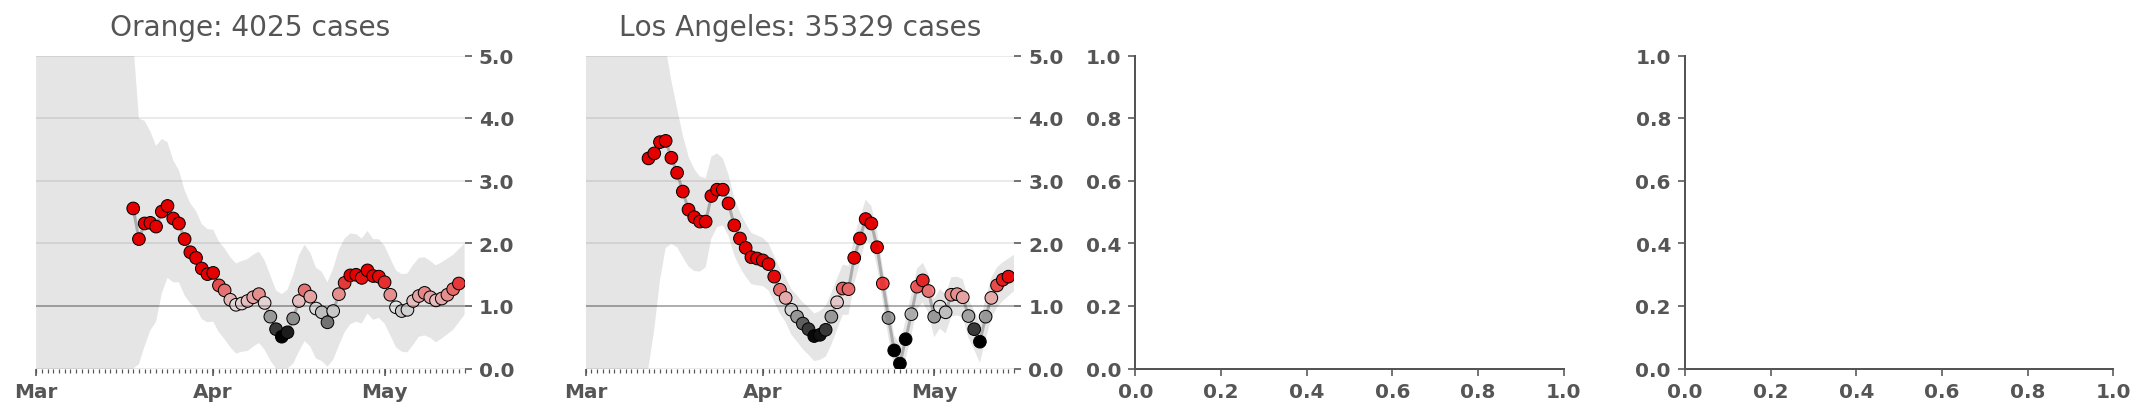


miami counties



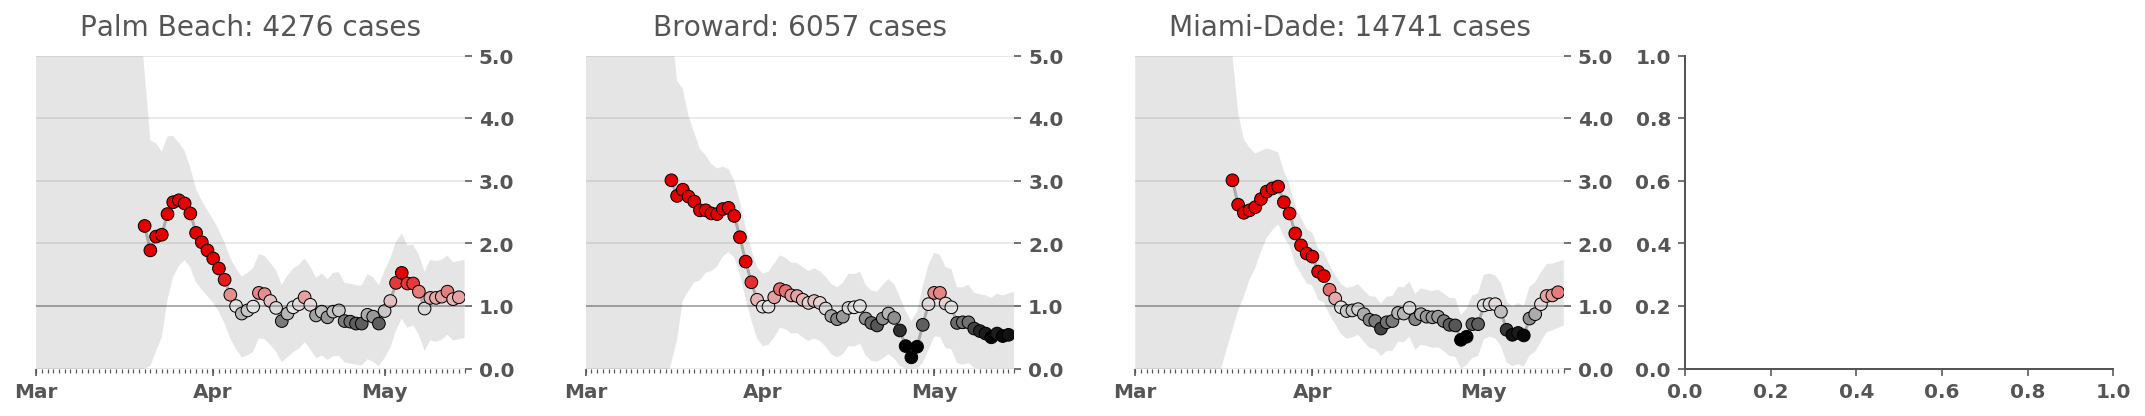


boston counties



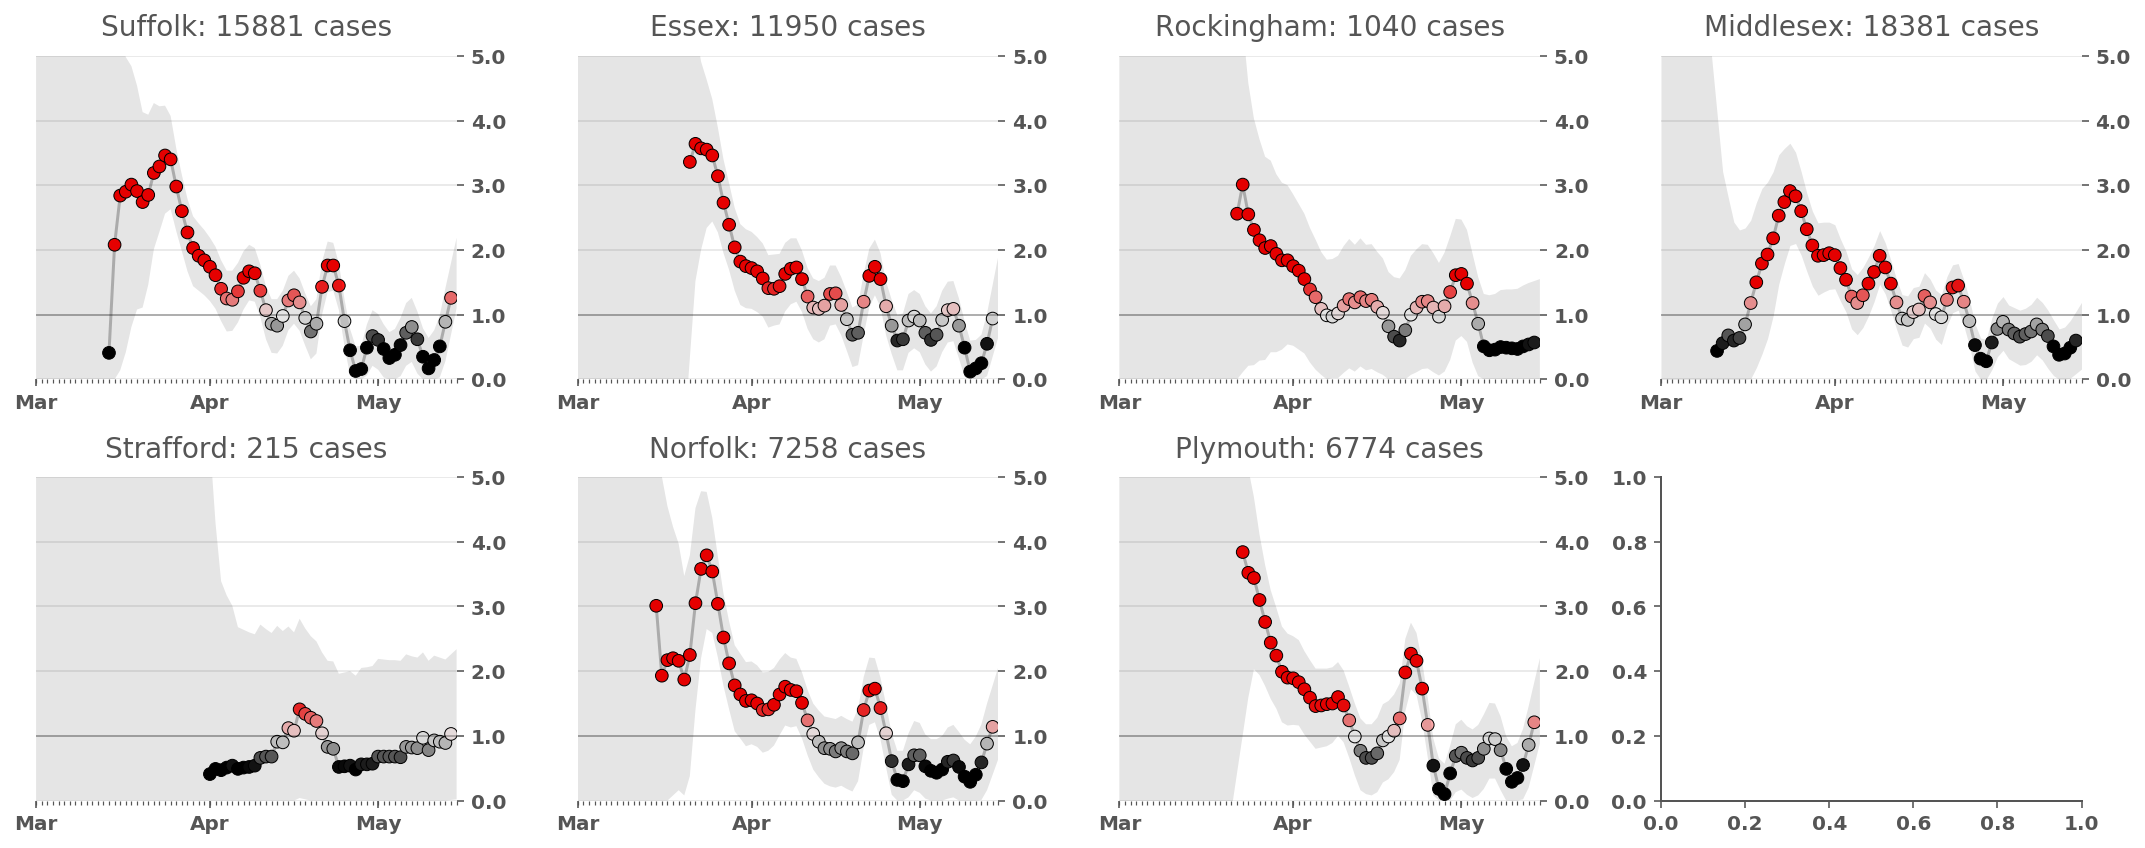


dallas counties



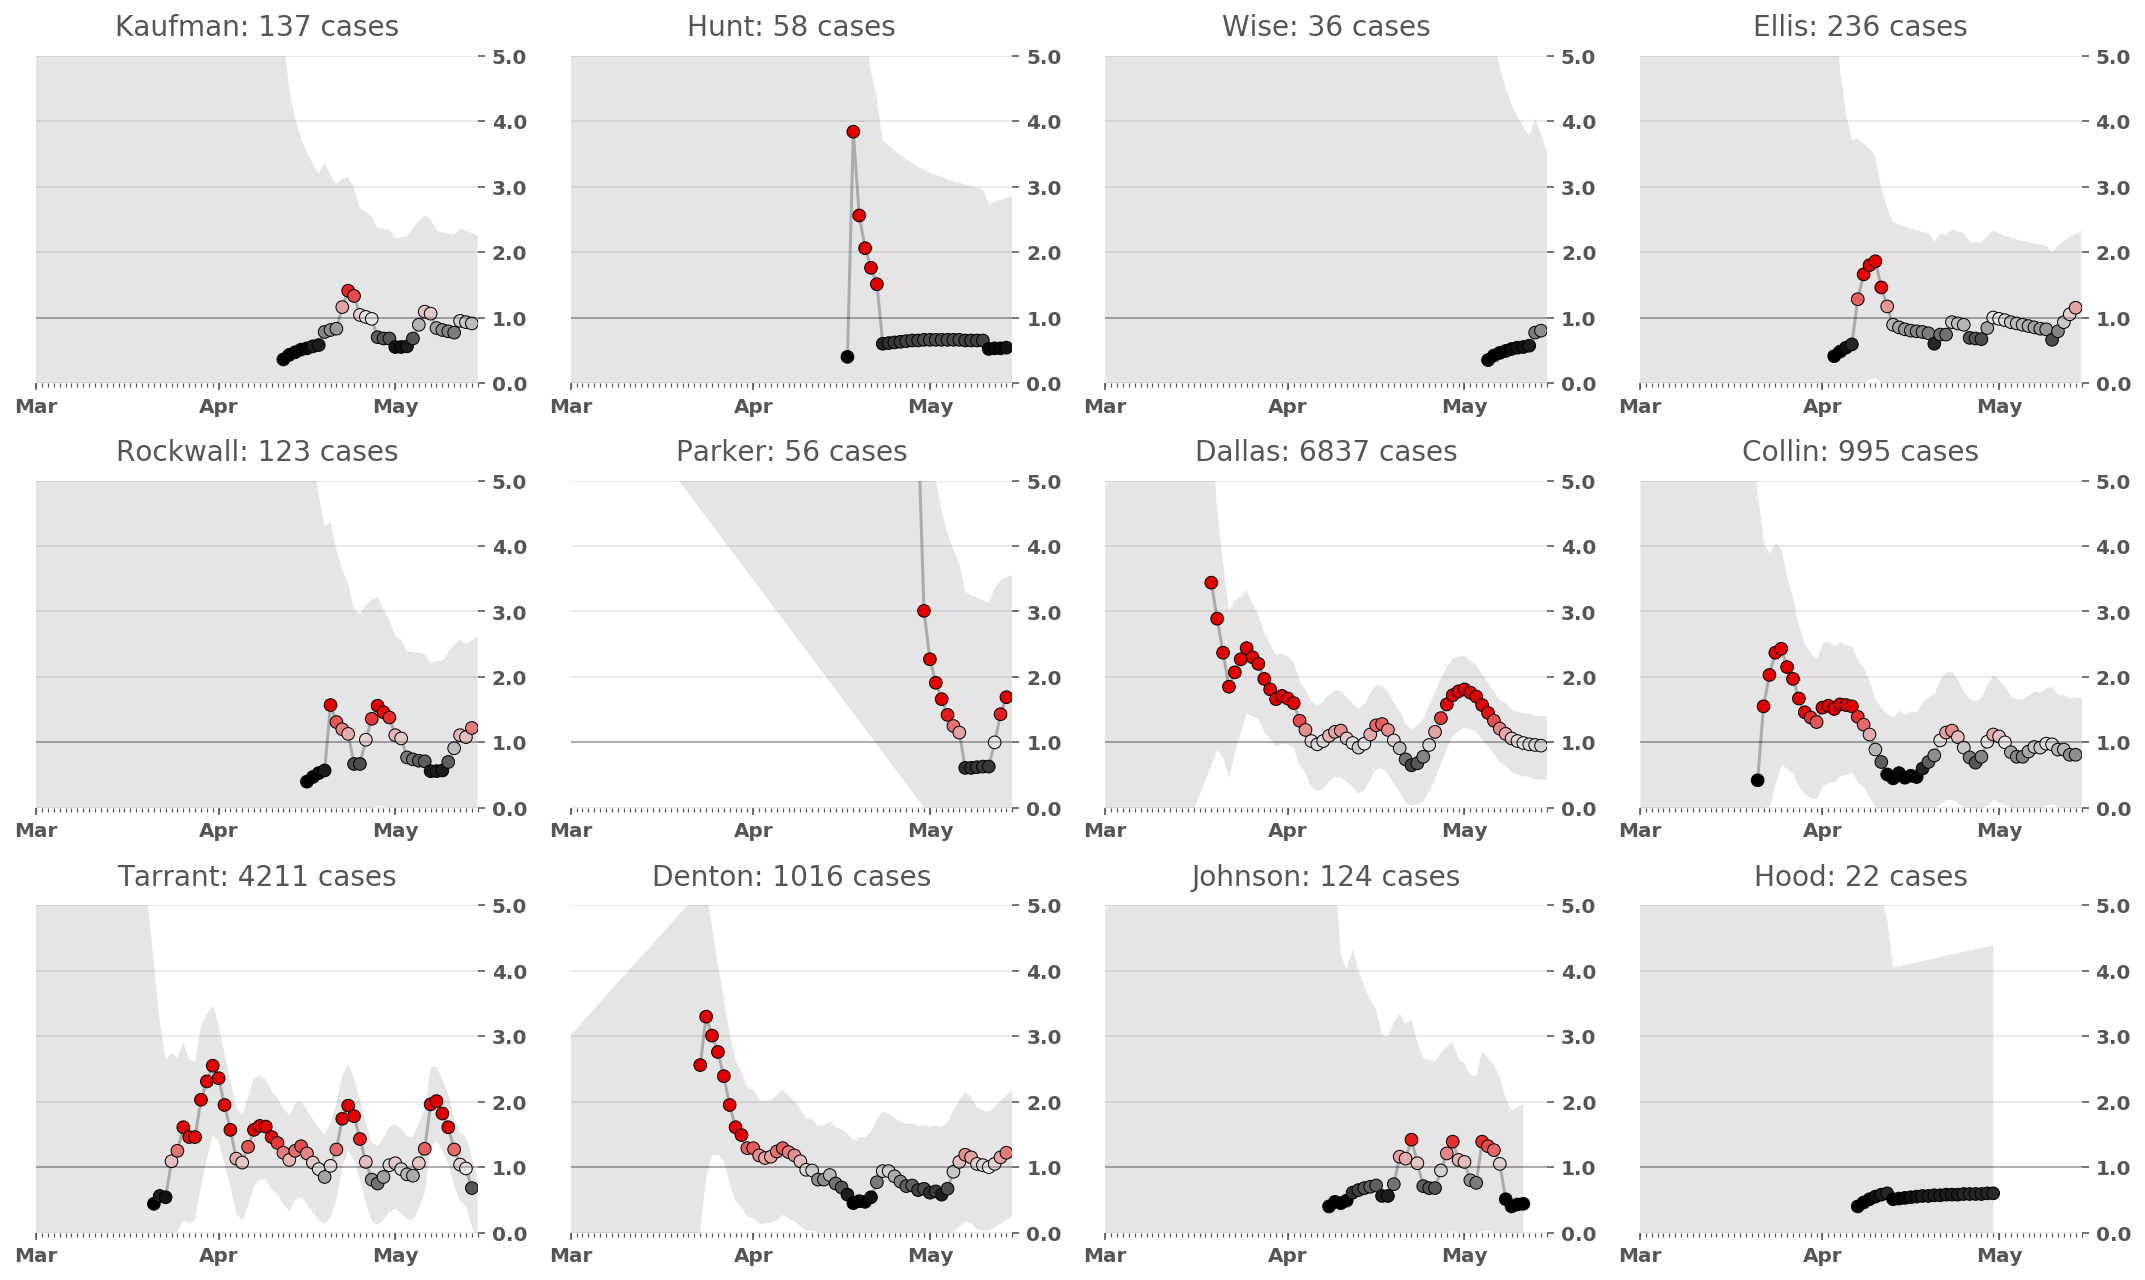


washington counties



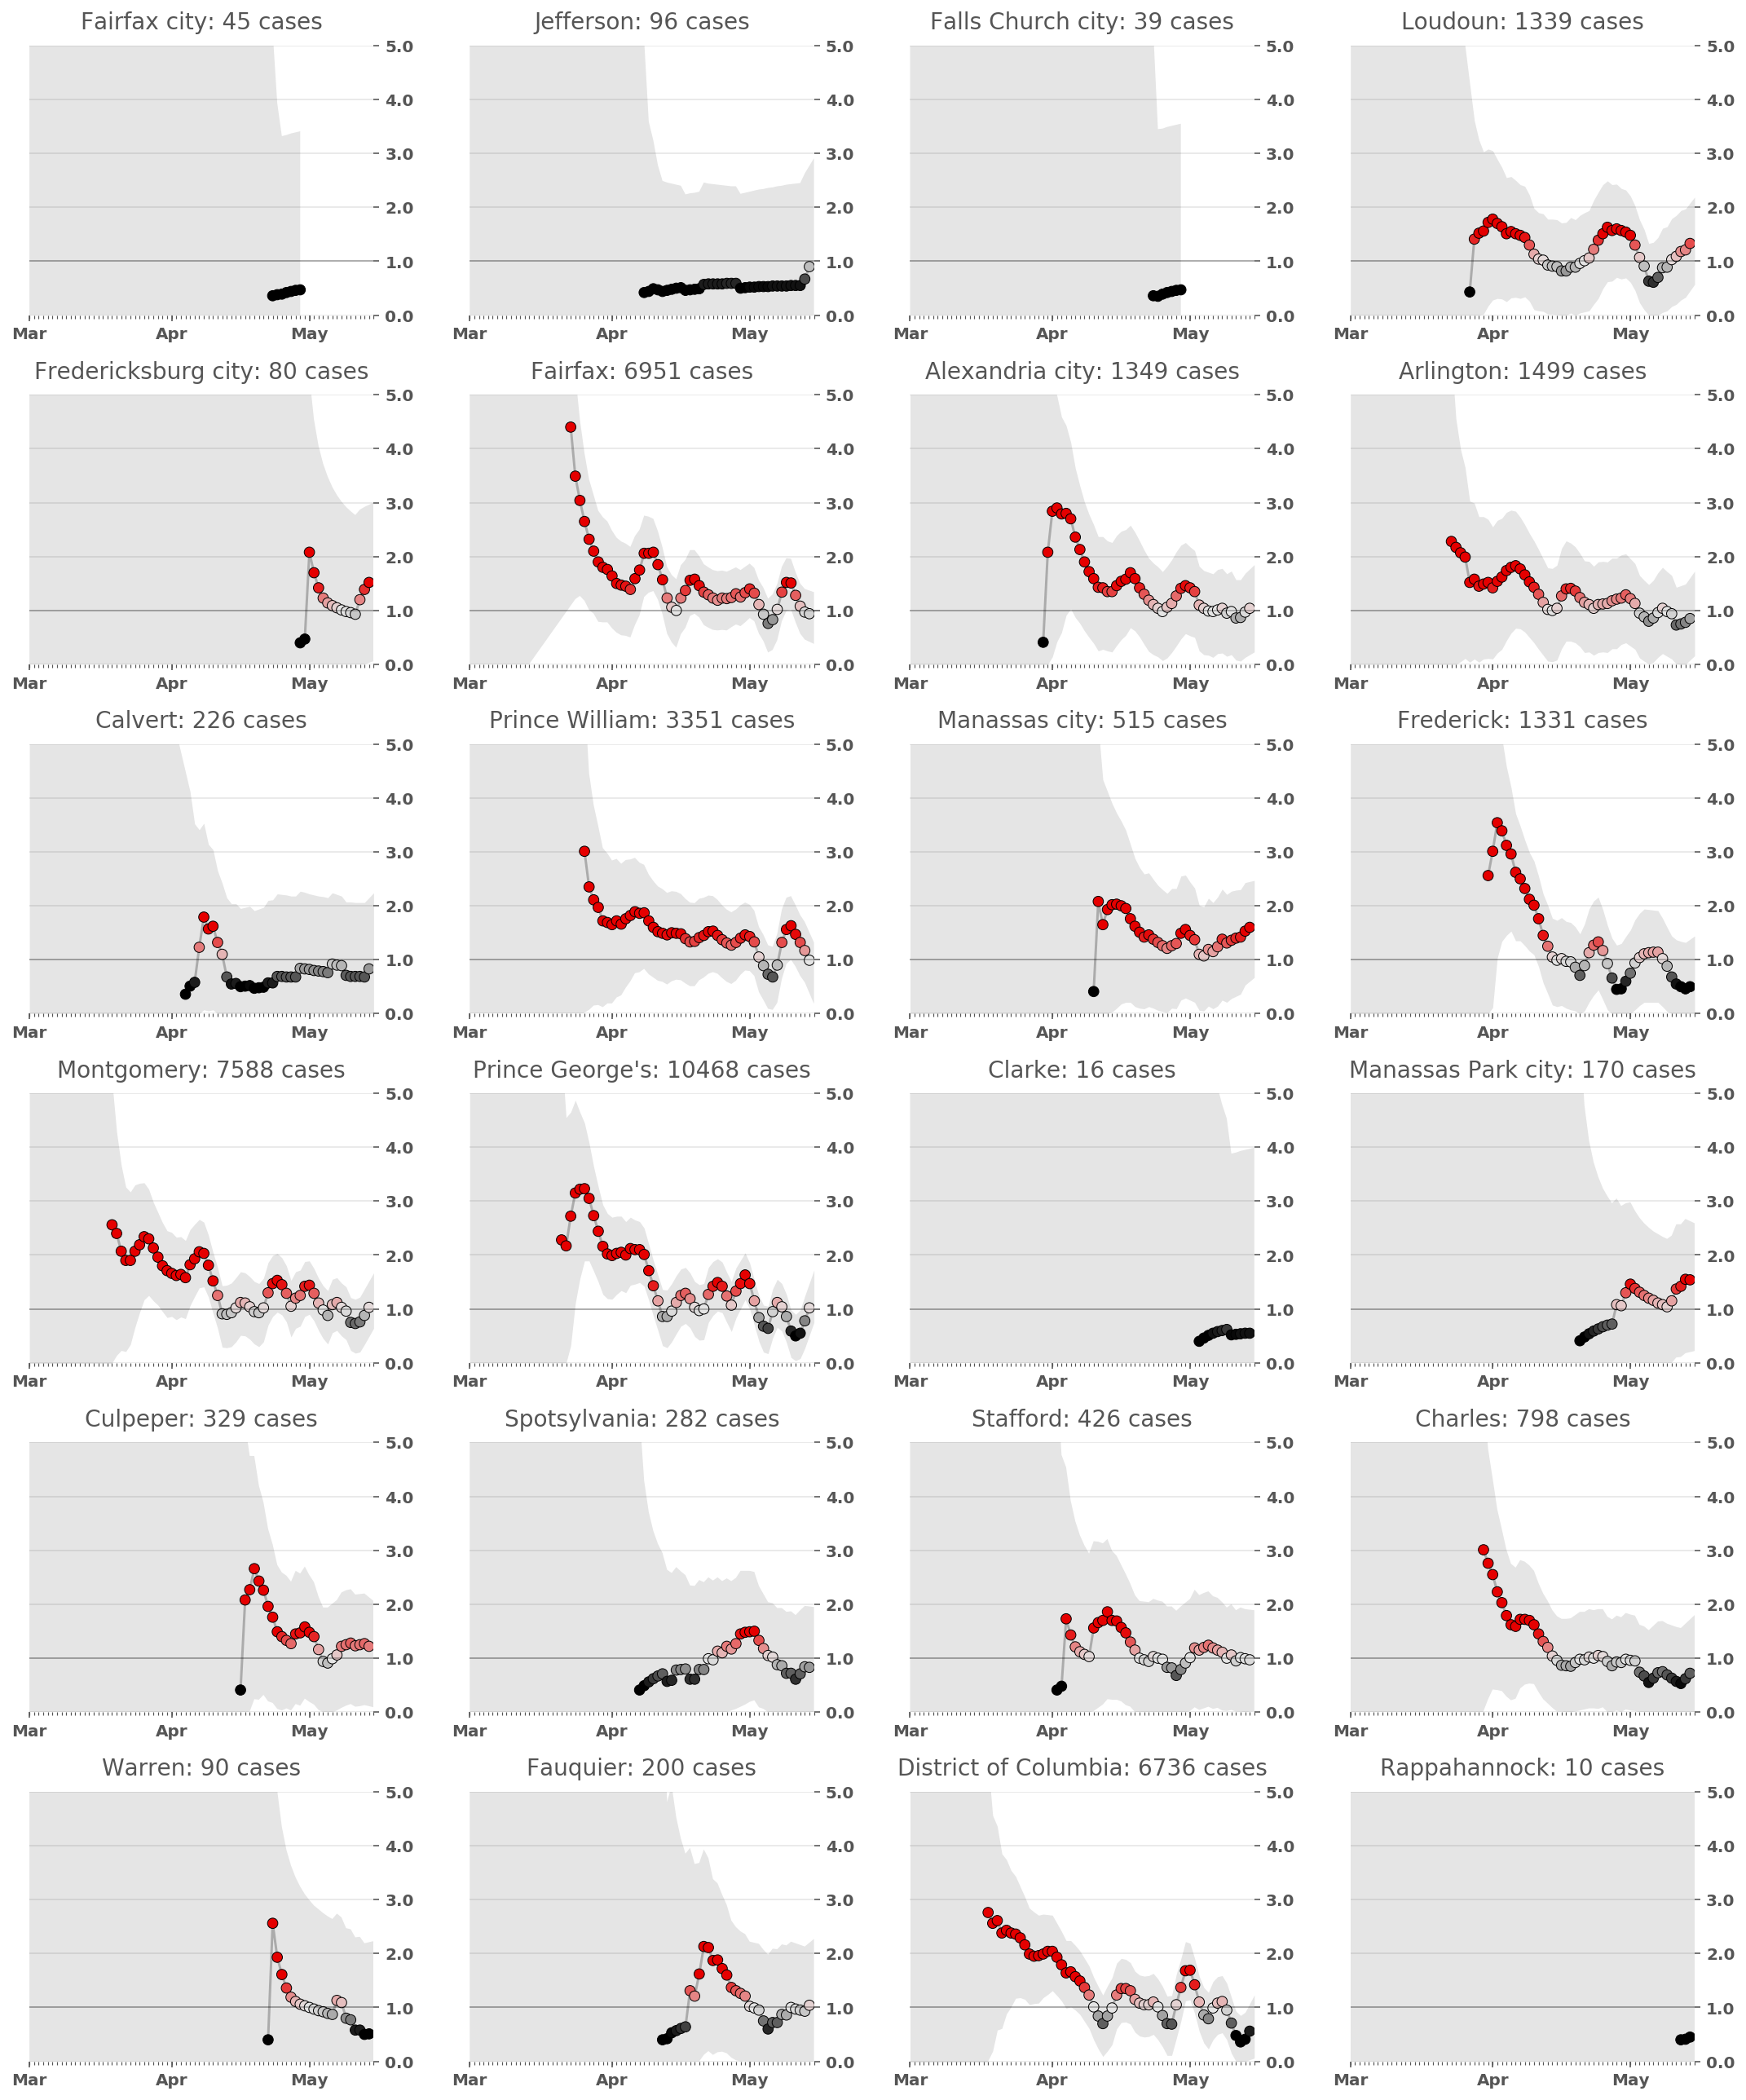


NY counties



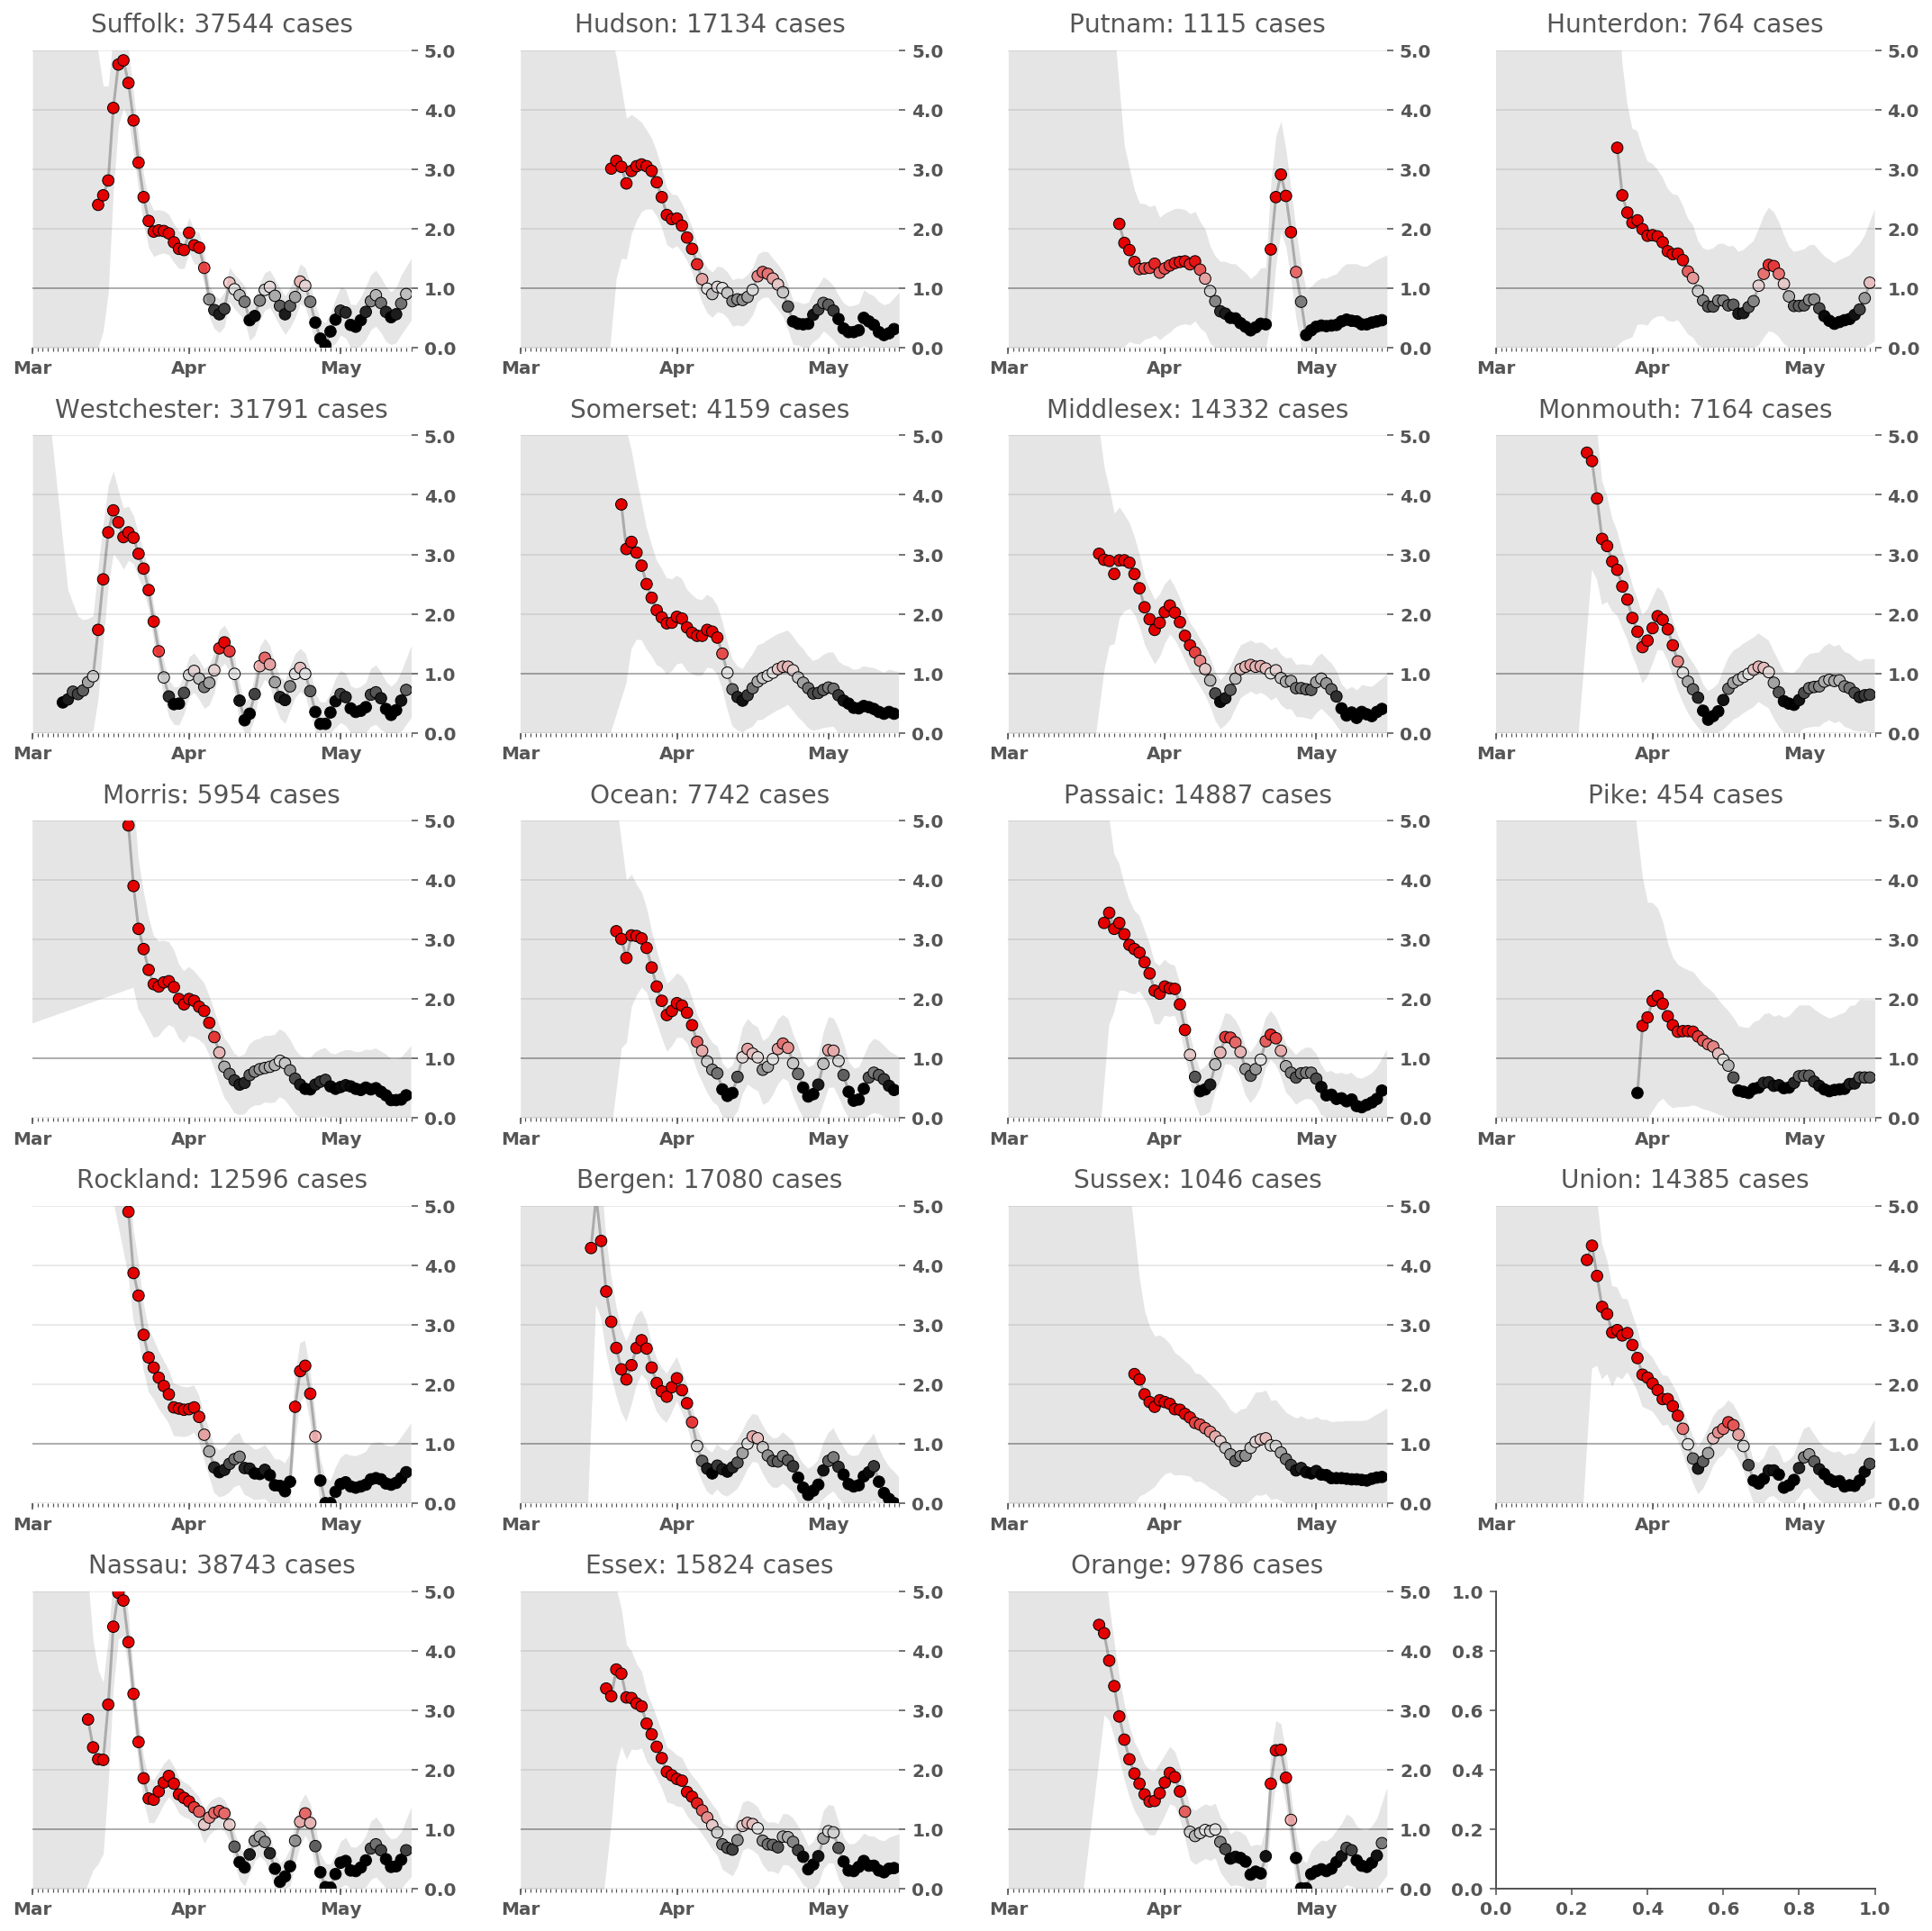


seattle counties



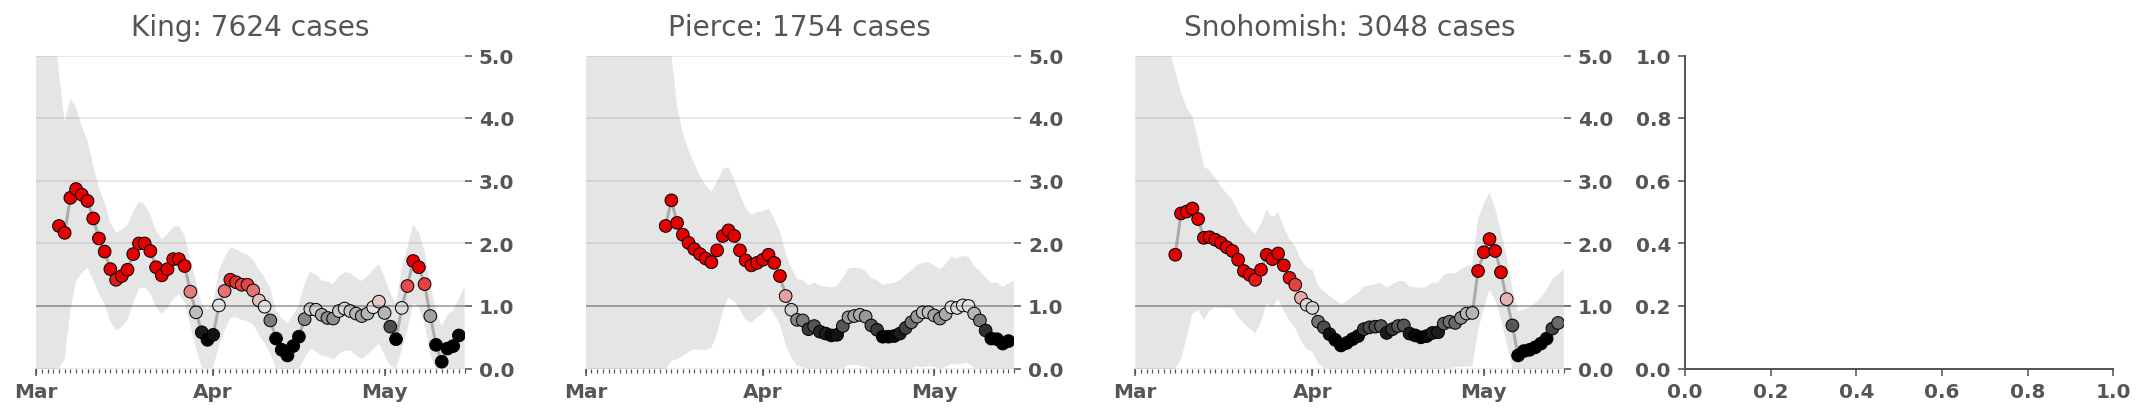


chicago counties



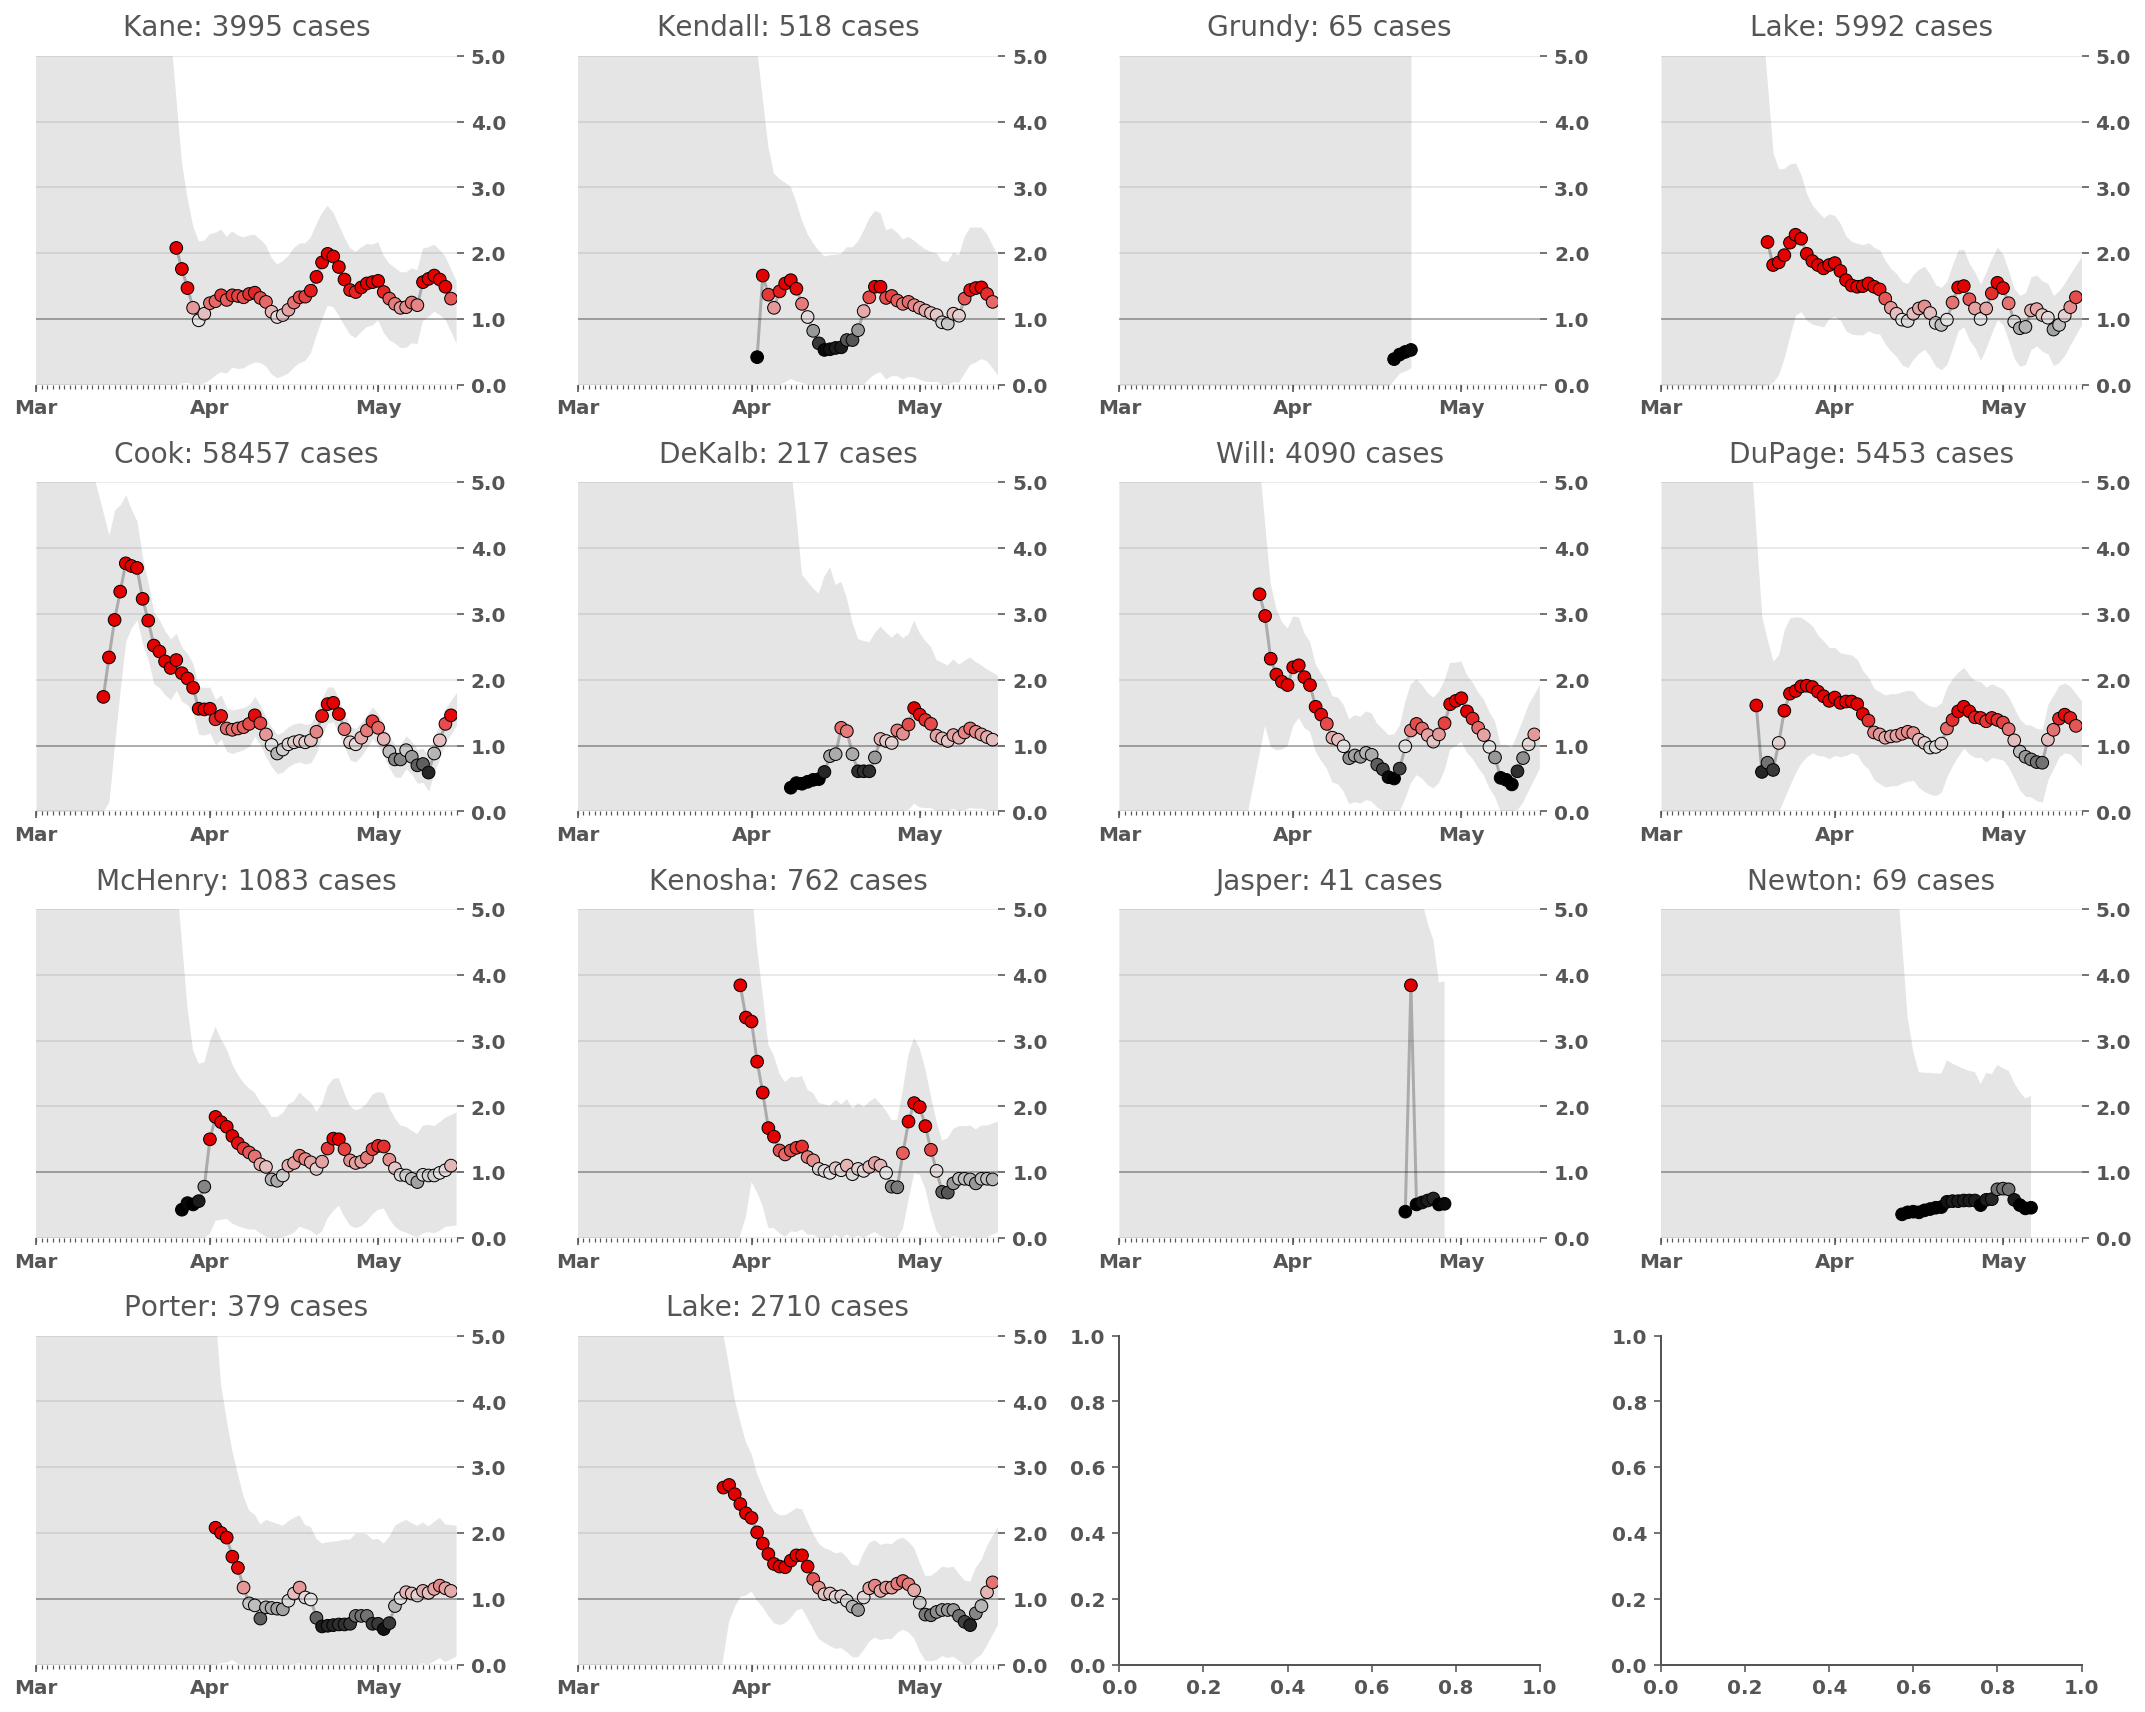

In [274]:
# plot results

for metro_area, county_results in metro_area_county_results.items():
    print('\n{} counties\n'.format(metro_area))
    
    ncols = 4
    nrows = int(np.ceil(float(len(county_results)) / float(ncols)))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (fips, result) in enumerate(county_results.items()):
        name = result['county'][-1]
        cumulative_cases = result.iloc[-1]['cumulative_cases']
        # print(i, fips, name, cumulative_cases)
        plot_title = '%s: %s cases' % (name, int(cumulative_cases))
        plot_rt(result, axes.flat[i], plot_title)

    fig.tight_layout()
    fig.set_facecolor('w')
    plt.show()


In [275]:
# Export the  data to CSV

for metro_area, county_results in metro_area_county_results.items():
    if not len(county_results):
        print('no results for %s. skipping.' % metro_area)
        continue
    counties_rts_fname = county_rts_fnames[metro_area]
    print('saving Rt data for {} to file: {}'.format(metro_area, counties_rts_fname))
    counties_rts = None

    for fips, result in county_results.items():
        r = result.copy()
        r.index = pd.MultiIndex.from_product([[fips], result.index], names=['fips', 'date'])
        if counties_rts is None:
            counties_rts = r
        else:
            counties_rts = pd.concat([counties_rts, r])

    counties_rts.sort_index(inplace=True)

    counties_rts.to_csv(counties_rts_fname)
    print('saved.')
counties_rts

saving Rt data for LA to file: /data/covid/LA/LA_counties_rt.csv
saved.
saving Rt data for miami to file: /data/covid/miami/miami_counties_rt.csv
saved.
saving Rt data for boston to file: /data/covid/boston/boston_counties_rt.csv
saved.
saving Rt data for dallas to file: /data/covid/dallas/dallas_counties_rt.csv
saved.
saving Rt data for washington to file: /data/covid/washington/washington_counties_rt.csv
saved.
saving Rt data for NY to file: /data/covid/NY_counties_rt.csv
saved.
saving Rt data for seattle to file: /data/covid/seattle/seattle_counties_rt.csv
saved.
saving Rt data for chicago to file: /data/covid/chicago/chicago_counties_rt.csv
saved.


ML  Low_90  High_90  cumulative_cases  new_cases  \
fips    date                                                             
17031.0 2020-03-13  1.74    0.00     4.53                40       13.0   
        2020-03-14  2.34    0.15     4.20                51       11.0   
        2020-03-15  2.91    1.02     4.58                76       25.0   
        2020-03-16  3.34    1.85     4.66                76        0.0   
        2020-03-17  3.77    2.59     4.81               107       31.0   
        2020-03-18  3.73    2.79     4.59               179       72.0   
        2020-03-19  3.70    2.91     4.41               279      100.0   
        2020-03-20  3.23    2.55     3.85               412      133.0   
        2020-03-21  2.90    2.30     3.47               548      136.0   
        2020-03-22  2.52    1.94     3.03               805      257.0   
        2020-03-23  2.43    1.88     2.91               922      117.0   
        2020-03-24  2.28    1.77     2.74              1194      272.0   
        2020-03-25  2.18    1.70     2.62              1418      224.0   
        2020-03-26  2.30    1.84     2.71              1904      486.0   
        2020-03-27  2.10    1.67     2.49              2239      335.0   
        2020-03-28  2.02    1.62     2.40              2613      374.0   
        2020-03-29  1.88    1.49     2.24              3445      832.0   
        2020-03-30  1.56    1.17     1.90              3727      282.0   
        2020-03-31  1.55    1.16     1.88              4496      769.0   
        2020-04-01  1.56    1.19     1.89              5152      656.0   
        2020-04-02  1.40    1.01     1.70              5575      423.0   
        2020-04-03  1.45    1.10     1.77              6473      898.0   
        2020-04-04  1.26    0.91     1.57              7439      966.0   
        2020-04-05  1.24    0.88     1.54              8043      604.0   
        2020-04-06  1.26    0.91     1.56              8728      685.0   
        2020-04-07  1.28    0.94     1.58              9509      781.0   
        2020-04-08  1.33    0.99     1.62             10520     1011.0   
        2020-04-09  1.46    1.14     1.75             11415      895.0   
        2020-04-10  1.34    1.01     1.61             12472     1057.0   
        2020-04-11  1.17    0.83     1.43             13417      945.0   
...                  ...     ...      ...               ...        ...   
55059.0 2020-04-15  0.99    0.00     2.01               204       18.0   
        2020-04-16  1.06    0.05     2.10               208        4.0   
        2020-04-17  1.03    0.00     2.03               218       10.0   
        2020-04-18  1.10    0.05     2.11               236       18.0   
        2020-04-19  0.97    0.00     1.97               248       12.0   
        2020-04-20  1.05    0.04     2.05               257        9.0   
        2020-04-21  1.02    0.00     1.99               264        7.0   
        2020-04-22  1.08    0.05     2.07               278       14.0   
        2020-04-23  1.14    0.09     2.13               294       16.0   
        2020-04-24  1.10    0.03     2.04               314       20.0   
        2020-04-25  0.99    0.01     1.93               329       15.0   
        2020-04-26  0.78    0.00     1.79               339       10.0   
        2020-04-27  0.77    0.00     1.80               340        1.0   
        2020-04-28  1.29    0.14     2.26               348        8.0   
        2020-04-29  1.77    0.58     2.79               363       15.0   
        2020-04-30  2.05    0.98     3.04               391       28.0   
        2020-05-01  1.99    0.96     2.88               477       86.0   
        2020-05-02  1.70    0.75     2.57               521       44.0   
        2020-05-03  1.34    0.38     2.15               534       13.0   
        2020-05-04  1.02    0.10     1.77               546       12.0   
        2020-05-05  0.70    0.00     1.48               571       25.0   
        2020-05-06  0.69  